# 3D patch-based segmentation with U-Net

Code started from [Francesco's tutorials](https://github.com/FrancescoLR/tutorials)



## Imports

In [1]:
import glob
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile
import matplotlib.pyplot as plt


import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, decollate_batch, DataLoader, CacheDataset, Dataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU, compute_meaniou
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ResizeWithPadOrCropd,
    RandCropByPosNegLabeld,
    Lambdad,
    ScaleIntensityd,
)
from monai.utils import first

import ignite
import torch, torchvision

print_config()

/home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.1rc3
Numpy version: 1.22.4
Pytorch version: 1.12.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7a5de8b7b9db101a431e70ae2aa8ea7ebb8dfffe
MONAI __file__: /home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.1+cu116
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup 


### Paths and cuda check

In [2]:
main_dir = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/'
data_dir = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/' # train and validation
test_data_dir = '/mnt/sda1/Repos/a-eye/Data'

[print(f"Data directory is: {data_dir}") if os.path.isdir(data_dir) else print("Check your data directory")]
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(torch.cuda.is_available())

Data directory is: /mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/
True


### Set images and segmentation paths

In [3]:
train_images_1 = []
train_labels_1 = []
validation_images = []
validation_labels = []

# List of subjects taken for the template construction
best_subjects_cc = ['sub-02','sub-03','sub-08','sub-09','sub-20','sub-29','sub-30','sub-33','sub-34'] # 9

# List of remaining subjects
all_subjects = list()
for i in range(35):
    all_subjects.append('sub-'+str(i+1).zfill(2))
rest_subjects = [elem for elem in all_subjects if elem not in best_subjects_cc]

# Train (rest subjects)
for i in range(len(rest_subjects)):
    input_t1 = data_dir + 'a123/' + rest_subjects[i] + '/input/' + rest_subjects[i] + '_T1.nii.gz'
    input_labels = data_dir + 'a123/' + rest_subjects[i] + '/input/' + rest_subjects[i] + '_labels.nii.gz'
    train_images_1.append(input_t1)
    train_labels_1.append(input_labels)
# Train dictionary
data_train_dicts_1 = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images_1, train_labels_1)
]   

# Validation (best subjects)
for i in range(len(best_subjects_cc)):
    input_t1 = data_dir + 'a123/' + best_subjects_cc[i] + '/input/' + best_subjects_cc[i] + '_T1.nii.gz'
    input_labels = data_dir + 'a123/' + best_subjects_cc[i] + '/input/' + best_subjects_cc[i] + '_labels.nii.gz'
    validation_images.append(input_t1)
    validation_labels.append(input_labels)
# Validation dictionary
data_validation_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(validation_images, validation_labels)
]

num_train_samples = len(data_train_dicts_1)
num_validation_samples = len(data_validation_dicts)
num_total_samples = num_train_samples + num_validation_samples
print(f"Train dataset is composed by {len(data_train_dicts_1)} ({num_train_samples/num_total_samples*100:.2f}%) subjects and validation by {len(data_validation_dicts)} ({num_validation_samples/num_total_samples*100:.2f}%).")

Train dataset is composed by 26 (74.29%) subjects and validation by 9 (25.71%).


### Set transforms and dataset

In [14]:
# Function to crop the eye from the medical image
def masked(data_dict):
    eye_mask = (data_dict["label"] != 0)
    eye_mask[eye_mask == True] = 1
    eye_mask[eye_mask == False] = 0
    data_dict["image"] = data_dict["image"] * eye_mask

    return data_dict
    
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), #Load image file or files from provided path based on reader.
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        ScaleIntensityd(keys=["image"]), #Scale the intensity of input image to the given value range (minv, maxv). If minv and maxv and factor not provided, Normalize the data
        EnsureChannelFirstd(keys=["image", "label"]), #Automatically adjust or add the channel dimension of input data to ensure channel_first shape.
        Orientationd(keys=["image", "label"], axcodes="RAS"), #Change the input image’s orientation into the specified based on axcodes.
        Spacingd(keys=["image", "label"], pixdim=(
            1, 1, 1), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(160, 160, 160)),
        masked,
        RandCropByPosNegLabeld( #Crop random fixed sized regions with the center being a foreground or background voxel based on the Pos Neg Ratio. I recommend to use it since improves dice and IoU score
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]    
)

validation_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        ScaleIntensityd(keys=["image"],),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1, 1, 1), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(160, 160, 160)),
        masked,
        RandCropByPosNegLabeld( #Crop random fixed sized regions with the center being a foreground or background voxel based on the Pos Neg Ratio. 
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=1,
            image_key="image",
            image_threshold=0,
        ),
    ]
)

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to try the regular Dataset, just change to use the commented code below.

In [15]:
train_ds = CacheDataset(
    data=data_train_dicts_1, transform=train_transforms,
    cache_rate=1.0, num_workers=8)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=8)

validation_ds = CacheDataset(
    data=data_validation_dicts, transform=validation_transforms, cache_rate=1.0, num_workers=8)
# val_ds = Dataset(data=val_files, transform=val_transforms)
validation_loader = DataLoader(validation_ds, batch_size=1, shuffle=False, num_workers=8)

Loading dataset: 100%|██████████| 9/9 [00:00<00:00, 10.12it/s]


#### Check transforms in DataLoader

N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


image shape: (96, 96, 96), label shape: (96, 96, 96)


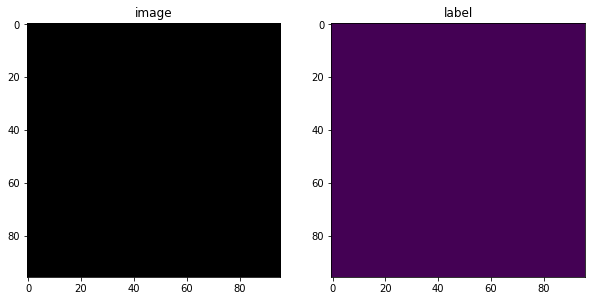

In [6]:
data_iter = iter(validation_loader)
random_data = data_iter.next()
image, label = (random_data["image"][0][0], random_data["label"][0][0]) # [0][0] is to show only the image shape
print(f"image shape: {image.shape}, label shape: {label.shape}")

# plot the slice [:, :, 80]
plt.figure("check", (10,5))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()
#print(len(torch.unique(label)))

#### Save transformed images from validation_loader

In [16]:
# '''
import SimpleITK as sitk

# Saving validation_loader images
i = 0
for _, dict in enumerate(validation_loader):
    print(f"dict: {dict['image'].shape}")
    im_tensors = dict['image']
    print(im_tensors[0].detach().cpu().numpy().shape)
    im_trans = sitk.GetImageFromArray(np.transpose(im_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    sitk.WriteImage(im_trans, main_dir+'im_trans'+str(i)+'.nii.gz')
    i += 1
    if i == 1:
        break
# '''

N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


dict: (1, 1, 96, 96, 96)
(1, 96, 96, 96)


## Training

### Create Model, Loss, Optimizer

In [8]:
# Create UNet, DiceLoss and Adam optimizer
import gc 
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 10,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    dropout = 0.5
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")

### Train 

In [9]:
FILE = "v2_num_samples_4.pth"

max_epochs = 150
val_interval = 1
best_metric = -1
best_metric_epoch = -1

epoch_train_loss_values = []
epoch_validation_loss_values = []
metric_values = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=10)])
post_label = Compose([AsDiscrete(to_onehot=10)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_train_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            step_validation = 0
            epoch_validation_loss = 0
            for validation_data in validation_loader:
                step_validation += 1
                validation_inputs, validation_labels = (
                    validation_data["image"].to(device),
                    validation_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4

                # Forward pass
                validation_predictions = model(validation_inputs)
                validation_loss = loss_function(validation_predictions, validation_labels)
                epoch_validation_loss += validation_loss.item()

                # Inference
                validation_outputs = sliding_window_inference(
                    validation_inputs, roi_size, sw_batch_size, model)
                validation_outputs = [post_pred(i) for i in decollate_batch(validation_outputs)]
                validation_labels = [post_label(i) for i in decollate_batch(validation_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=validation_outputs, y=validation_labels)

            epoch_validation_loss /= step_validation
            epoch_validation_loss_values.append(epoch_validation_loss)
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    main_dir, FILE))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/150


N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.9760
2/13, train_loss: 0.9730
3/13, train_loss: 0.9690
4/13, train_loss: 0.9660
5/13, train_loss: 0.9623
6/13, train_loss: 0.9590
7/13, train_loss: 0.9544
8/13, train_loss: 0.9488
9/13, train_loss: 0.9475
10/13, train_loss: 0.9432
11/13, train_loss: 0.9376
12/13, train_loss: 0.9336
13/13, train_loss: 0.9304
epoch 1 average loss: 0.9539


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 1 current mean dice: 0.0248
best mean dice: 0.0248at epoch: 1
----------
epoch 2/150


N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to genera

1/13, train_loss: 0.9256
2/13, train_loss: 0.9224
3/13, train_loss: 0.9152
4/13, train_loss: 0.9131
5/13, train_loss: 0.9116
6/13, train_loss: 0.9078
7/13, train_loss: 0.9054
8/13, train_loss: 0.8957
9/13, train_loss: 0.8925
10/13, train_loss: 0.8942
11/13, train_loss: 0.8870
12/13, train_loss: 0.8864
13/13, train_loss: 0.8693
epoch 2 average loss: 0.9020


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 2 current mean dice: 0.0985
best mean dice: 0.0985at epoch: 2
----------
epoch 3/150


N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to genera

1/13, train_loss: 0.8675
2/13, train_loss: 0.8758
3/13, train_loss: 0.8537
4/13, train_loss: 0.8488
5/13, train_loss: 0.8461
6/13, train_loss: 0.8414
7/13, train_loss: 0.8232
8/13, train_loss: 0.8227
9/13, train_loss: 0.8179
10/13, train_loss: 0.8072
11/13, train_loss: 0.7968
12/13, train_loss: 0.7950
13/13, train_loss: 0.7761
epoch 3 average loss: 0.8286


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 3 current mean dice: 0.1459
best mean dice: 0.1459at epoch: 3
----------
epoch 4/150


N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to genera

1/13, train_loss: 0.7772
2/13, train_loss: 0.7657
3/13, train_loss: 0.7559
4/13, train_loss: 0.7561
5/13, train_loss: 0.7465
6/13, train_loss: 0.7497
7/13, train_loss: 0.7493
8/13, train_loss: 0.7417
9/13, train_loss: 0.7302
10/13, train_loss: 0.7269
11/13, train_loss: 0.7268
12/13, train_loss: 0.7082
13/13, train_loss: 0.7118
epoch 4 average loss: 0.7420


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 4 current mean dice: 0.1922
best mean dice: 0.1922at epoch: 4
----------
epoch 5/150


N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to genera

1/13, train_loss: 0.6960
2/13, train_loss: 0.7103
3/13, train_loss: 0.6912
4/13, train_loss: 0.6834
5/13, train_loss: 0.6773
6/13, train_loss: 0.6905
7/13, train_loss: 0.6652
8/13, train_loss: 0.6636
9/13, train_loss: 0.6814
10/13, train_loss: 0.6622
11/13, train_loss: 0.6812
12/13, train_loss: 0.6786
13/13, train_loss: 0.6456
epoch 5 average loss: 0.6790


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 5 current mean dice: 0.3396
best mean dice: 0.3396at epoch: 5
----------
epoch 6/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to genera

1/13, train_loss: 0.6466
2/13, train_loss: 0.6260
3/13, train_loss: 0.6221
4/13, train_loss: 0.6495
5/13, train_loss: 0.6350
6/13, train_loss: 0.6627
7/13, train_loss: 0.6198
8/13, train_loss: 0.5990
9/13, train_loss: 0.5929
10/13, train_loss: 0.5942
11/13, train_loss: 0.6016
12/13, train_loss: 0.5872
13/13, train_loss: 0.5916
epoch 6 average loss: 0.6176


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 6 current mean dice: 0.4830
best mean dice: 0.4830at epoch: 6
----------
epoch 7/150


N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to genera

1/13, train_loss: 0.5924
2/13, train_loss: 0.5761
3/13, train_loss: 0.5322
4/13, train_loss: 0.5604
5/13, train_loss: 0.5404
6/13, train_loss: 0.5253
7/13, train_loss: 0.5518
8/13, train_loss: 0.5875
9/13, train_loss: 0.5347
10/13, train_loss: 0.5104
11/13, train_loss: 0.5302
12/13, train_loss: 0.5095
13/13, train_loss: 0.5053
epoch 7 average loss: 0.5428


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 7 current mean dice: 0.4953
best mean dice: 0.4953at epoch: 7
----------
epoch 8/150


N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.5269
2/13, train_loss: 0.4925
3/13, train_loss: 0.4941
4/13, train_loss: 0.5097
5/13, train_loss: 0.4653
6/13, train_loss: 0.4699
7/13, train_loss: 0.4378
8/13, train_loss: 0.4735
9/13, train_loss: 0.4832
10/13, train_loss: 0.5013
11/13, train_loss: 0.4347
12/13, train_loss: 0.5227
13/13, train_loss: 0.4641
epoch 8 average loss: 0.4828


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 8 current mean dice: 0.5746
best mean dice: 0.5746at epoch: 8
----------
epoch 9/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generat

1/13, train_loss: 0.4270
2/13, train_loss: 0.4470
3/13, train_loss: 0.4223
4/13, train_loss: 0.4353
5/13, train_loss: 0.4743
6/13, train_loss: 0.4625
7/13, train_loss: 0.4298
8/13, train_loss: 0.4023
9/13, train_loss: 0.4150
10/13, train_loss: 0.4031
11/13, train_loss: 0.4238
12/13, train_loss: 0.3825
13/13, train_loss: 0.3601
epoch 9 average loss: 0.4219


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 9 current mean dice: 0.6331
best mean dice: 0.6331at epoch: 9
----------
epoch 10/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generat

1/13, train_loss: 0.3913
2/13, train_loss: 0.3644
3/13, train_loss: 0.3995
4/13, train_loss: 0.3700
5/13, train_loss: 0.3535
6/13, train_loss: 0.3987
7/13, train_loss: 0.4455
8/13, train_loss: 0.4156
9/13, train_loss: 0.3662
10/13, train_loss: 0.3855
11/13, train_loss: 0.4010
12/13, train_loss: 0.3331
13/13, train_loss: 0.3617
epoch 10 average loss: 0.3835


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 10 current mean dice: 0.7153
best mean dice: 0.7153at epoch: 10
----------
epoch 11/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to genera

1/13, train_loss: 0.3618
2/13, train_loss: 0.3620
3/13, train_loss: 0.3606
4/13, train_loss: 0.3723
5/13, train_loss: 0.3492
6/13, train_loss: 0.3278
7/13, train_loss: 0.3622
8/13, train_loss: 0.3303
9/13, train_loss: 0.3228
10/13, train_loss: 0.3071
11/13, train_loss: 0.3581
12/13, train_loss: 0.3309
13/13, train_loss: 0.3032
epoch 11 average loss: 0.3422


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 11 current mean dice: 0.7053
best mean dice: 0.7153at epoch: 10
----------
epoch 12/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to genera

1/13, train_loss: 0.3044
2/13, train_loss: 0.2858
3/13, train_loss: 0.2851
4/13, train_loss: 0.3551
5/13, train_loss: 0.3056
6/13, train_loss: 0.3139
7/13, train_loss: 0.3472
8/13, train_loss: 0.2985
9/13, train_loss: 0.3290
10/13, train_loss: 0.3166
11/13, train_loss: 0.3341
12/13, train_loss: 0.2987
13/13, train_loss: 0.3421
epoch 12 average loss: 0.3166


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 12 current mean dice: 0.7468
best mean dice: 0.7468at epoch: 12
----------
epoch 13/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to genera

1/13, train_loss: 0.2877
2/13, train_loss: 0.3258
3/13, train_loss: 0.3055
4/13, train_loss: 0.2820
5/13, train_loss: 0.2872
6/13, train_loss: 0.3037
7/13, train_loss: 0.2863
8/13, train_loss: 0.3325
9/13, train_loss: 0.2712
10/13, train_loss: 0.2725
11/13, train_loss: 0.3237
12/13, train_loss: 0.2726
13/13, train_loss: 0.3307
epoch 13 average loss: 0.2986


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 13 current mean dice: 0.7418
best mean dice: 0.7468at epoch: 12
----------
epoch 14/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generat

1/13, train_loss: 0.2551
2/13, train_loss: 0.3006
3/13, train_loss: 0.2500
4/13, train_loss: 0.2828
5/13, train_loss: 0.3134
6/13, train_loss: 0.2847
7/13, train_loss: 0.3333
8/13, train_loss: 0.2749
9/13, train_loss: 0.2957
10/13, train_loss: 0.2637
11/13, train_loss: 0.3081
12/13, train_loss: 0.2953
13/13, train_loss: 0.2655
epoch 14 average loss: 0.2864


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 14 current mean dice: 0.7615
best mean dice: 0.7615at epoch: 14
----------
epoch 15/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generat

1/13, train_loss: 0.2653
2/13, train_loss: 0.2699
3/13, train_loss: 0.3131
4/13, train_loss: 0.2858
5/13, train_loss: 0.2927
6/13, train_loss: 0.2816
7/13, train_loss: 0.2609
8/13, train_loss: 0.2417
9/13, train_loss: 0.2744
10/13, train_loss: 0.2980
11/13, train_loss: 0.2688
12/13, train_loss: 0.2531
13/13, train_loss: 0.2834
epoch 15 average loss: 0.2761


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 15 current mean dice: 0.7696
best mean dice: 0.7696at epoch: 15
----------
epoch 16/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.2645
2/13, train_loss: 0.2694
3/13, train_loss: 0.2533
4/13, train_loss: 0.2254
5/13, train_loss: 0.2793
6/13, train_loss: 0.2495
7/13, train_loss: 0.2539
8/13, train_loss: 0.2495
9/13, train_loss: 0.2917
10/13, train_loss: 0.2695
11/13, train_loss: 0.2899
12/13, train_loss: 0.2773
13/13, train_loss: 0.2545
epoch 16 average loss: 0.2637


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 16 current mean dice: 0.7737
best mean dice: 0.7737at epoch: 16
----------
epoch 17/150


N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generat

1/13, train_loss: 0.2492
2/13, train_loss: 0.2658
3/13, train_loss: 0.2604
4/13, train_loss: 0.2739
5/13, train_loss: 0.2684
6/13, train_loss: 0.2825
7/13, train_loss: 0.2618
8/13, train_loss: 0.2558
9/13, train_loss: 0.2440
10/13, train_loss: 0.2875
11/13, train_loss: 0.2409
12/13, train_loss: 0.2425
13/13, train_loss: 0.2736
epoch 17 average loss: 0.2620


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 17 current mean dice: 0.7819
best mean dice: 0.7819at epoch: 17
----------
epoch 18/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to genera

1/13, train_loss: 0.2332
2/13, train_loss: 0.2460
3/13, train_loss: 0.2502
4/13, train_loss: 0.2480
5/13, train_loss: 0.2284
6/13, train_loss: 0.2547
7/13, train_loss: 0.2696
8/13, train_loss: 0.2375
9/13, train_loss: 0.2461
10/13, train_loss: 0.2771
11/13, train_loss: 0.2868
12/13, train_loss: 0.2790
13/13, train_loss: 0.2507
epoch 18 average loss: 0.2544


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 18 current mean dice: 0.7805
best mean dice: 0.7819at epoch: 17
----------
epoch 19/150


N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to genera

1/13, train_loss: 0.2665
2/13, train_loss: 0.2405
3/13, train_loss: 0.2823
4/13, train_loss: 0.2477
5/13, train_loss: 0.2635
6/13, train_loss: 0.2794
7/13, train_loss: 0.2575
8/13, train_loss: 0.2360
9/13, train_loss: 0.2634
10/13, train_loss: 0.2278
11/13, train_loss: 0.2239
12/13, train_loss: 0.2528
13/13, train_loss: 0.2787
epoch 19 average loss: 0.2554


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 19 current mean dice: 0.7980
best mean dice: 0.7980at epoch: 19
----------
epoch 20/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to genera

1/13, train_loss: 0.2717
2/13, train_loss: 0.2490
3/13, train_loss: 0.2568
4/13, train_loss: 0.2493
5/13, train_loss: 0.2481
6/13, train_loss: 0.2720
7/13, train_loss: 0.2150
8/13, train_loss: 0.2821
9/13, train_loss: 0.2367
10/13, train_loss: 0.2452
11/13, train_loss: 0.2159
12/13, train_loss: 0.2531
13/13, train_loss: 0.2231
epoch 20 average loss: 0.2475


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 20 current mean dice: 0.8041
best mean dice: 0.8041at epoch: 20
----------
epoch 21/150


N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to genera

1/13, train_loss: 0.2369
2/13, train_loss: 0.2374
3/13, train_loss: 0.2295
4/13, train_loss: 0.2403
5/13, train_loss: 0.2109
6/13, train_loss: 0.2404
7/13, train_loss: 0.2514
8/13, train_loss: 0.2531
9/13, train_loss: 0.2483
10/13, train_loss: 0.2588
11/13, train_loss: 0.2107
12/13, train_loss: 0.2469
13/13, train_loss: 0.2124
epoch 21 average loss: 0.2367


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 21 current mean dice: 0.8044
best mean dice: 0.8044at epoch: 21
----------
epoch 22/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generat

1/13, train_loss: 0.2534
2/13, train_loss: 0.1973
3/13, train_loss: 0.2386
4/13, train_loss: 0.2613
5/13, train_loss: 0.2414
6/13, train_loss: 0.2340
7/13, train_loss: 0.2266
8/13, train_loss: 0.2431
9/13, train_loss: 0.2355
10/13, train_loss: 0.2354
11/13, train_loss: 0.2471
12/13, train_loss: 0.2136
13/13, train_loss: 0.2191
epoch 22 average loss: 0.2343


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 22 current mean dice: 0.8076
best mean dice: 0.8076at epoch: 22
----------
epoch 23/150


N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generat

1/13, train_loss: 0.2076
2/13, train_loss: 0.2147
3/13, train_loss: 0.2229
4/13, train_loss: 0.2572
5/13, train_loss: 0.2218
6/13, train_loss: 0.2341
7/13, train_loss: 0.2268
8/13, train_loss: 0.2358
9/13, train_loss: 0.2565
10/13, train_loss: 0.2191
11/13, train_loss: 0.2113
12/13, train_loss: 0.2131
13/13, train_loss: 0.2315
epoch 23 average loss: 0.2271


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 23 current mean dice: 0.8141
best mean dice: 0.8141at epoch: 23
----------
epoch 24/150


N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.2080
2/13, train_loss: 0.2362
3/13, train_loss: 0.2047
4/13, train_loss: 0.2194
5/13, train_loss: 0.2062
6/13, train_loss: 0.2161
7/13, train_loss: 0.2300
8/13, train_loss: 0.2237
9/13, train_loss: 0.2490
10/13, train_loss: 0.2215
11/13, train_loss: 0.2517
12/13, train_loss: 0.2124
13/13, train_loss: 0.2323
epoch 24 average loss: 0.2239


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 24 current mean dice: 0.8186
best mean dice: 0.8186at epoch: 24
----------
epoch 25/150


N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to genera

1/13, train_loss: 0.2484
2/13, train_loss: 0.2378
3/13, train_loss: 0.2029
4/13, train_loss: 0.2197
5/13, train_loss: 0.2161
6/13, train_loss: 0.2218
7/13, train_loss: 0.2249
8/13, train_loss: 0.2211
9/13, train_loss: 0.2102
10/13, train_loss: 0.2122
11/13, train_loss: 0.2290
12/13, train_loss: 0.1971
13/13, train_loss: 0.1973
epoch 25 average loss: 0.2184


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 25 current mean dice: 0.8159
best mean dice: 0.8186at epoch: 24
----------
epoch 26/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generat

1/13, train_loss: 0.2154
2/13, train_loss: 0.2186
3/13, train_loss: 0.2048
4/13, train_loss: 0.2106
5/13, train_loss: 0.2460
6/13, train_loss: 0.1988
7/13, train_loss: 0.2567
8/13, train_loss: 0.2116
9/13, train_loss: 0.2221
10/13, train_loss: 0.2092
11/13, train_loss: 0.1951
12/13, train_loss: 0.2306
13/13, train_loss: 0.2027
epoch 26 average loss: 0.2171


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 26 current mean dice: 0.8151
best mean dice: 0.8186at epoch: 24
----------
epoch 27/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to genera

1/13, train_loss: 0.2057
2/13, train_loss: 0.1824
3/13, train_loss: 0.2331
4/13, train_loss: 0.1912
5/13, train_loss: 0.2066
6/13, train_loss: 0.2422
7/13, train_loss: 0.2105
8/13, train_loss: 0.2138
9/13, train_loss: 0.2428
10/13, train_loss: 0.2146
11/13, train_loss: 0.2021
12/13, train_loss: 0.2333
13/13, train_loss: 0.2455
epoch 27 average loss: 0.2172


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 27 current mean dice: 0.8142
best mean dice: 0.8186at epoch: 24
----------
epoch 28/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to genera

1/13, train_loss: 0.2186
2/13, train_loss: 0.2247
3/13, train_loss: 0.1979
4/13, train_loss: 0.2088
5/13, train_loss: 0.2050
6/13, train_loss: 0.2010
7/13, train_loss: 0.2354
8/13, train_loss: 0.2287
9/13, train_loss: 0.1970
10/13, train_loss: 0.2101
11/13, train_loss: 0.2324
12/13, train_loss: 0.2037
13/13, train_loss: 0.1997
epoch 28 average loss: 0.2125


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 28 current mean dice: 0.8192
best mean dice: 0.8192at epoch: 28
----------
epoch 29/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.1812
2/13, train_loss: 0.1993
3/13, train_loss: 0.2370
4/13, train_loss: 0.1965
5/13, train_loss: 0.2329
6/13, train_loss: 0.2079
7/13, train_loss: 0.2240
8/13, train_loss: 0.1997
9/13, train_loss: 0.2151
10/13, train_loss: 0.1961
11/13, train_loss: 0.2196
12/13, train_loss: 0.2018
13/13, train_loss: 0.2034
epoch 29 average loss: 0.2088


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 29 current mean dice: 0.8215
best mean dice: 0.8215at epoch: 29
----------
epoch 30/150


N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to genera

1/13, train_loss: 0.1963
2/13, train_loss: 0.1936
3/13, train_loss: 0.2074
4/13, train_loss: 0.2131
5/13, train_loss: 0.1830
6/13, train_loss: 0.2062
7/13, train_loss: 0.2287
8/13, train_loss: 0.1936
9/13, train_loss: 0.2358
10/13, train_loss: 0.2031
11/13, train_loss: 0.2032
12/13, train_loss: 0.1864
13/13, train_loss: 0.2022
epoch 30 average loss: 0.2041


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 30 current mean dice: 0.8379
best mean dice: 0.8379at epoch: 30
----------
epoch 31/150


N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.2004
2/13, train_loss: 0.2181
3/13, train_loss: 0.2080
4/13, train_loss: 0.2225
5/13, train_loss: 0.2388
6/13, train_loss: 0.1873
7/13, train_loss: 0.1926
8/13, train_loss: 0.1806
9/13, train_loss: 0.1962
10/13, train_loss: 0.2014
11/13, train_loss: 0.1971
12/13, train_loss: 0.1838
13/13, train_loss: 0.1936
epoch 31 average loss: 0.2016


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 31 current mean dice: 0.8351
best mean dice: 0.8379at epoch: 30
----------
epoch 32/150


N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generat

1/13, train_loss: 0.2136
2/13, train_loss: 0.2080
3/13, train_loss: 0.2137
4/13, train_loss: 0.1966
5/13, train_loss: 0.1731
6/13, train_loss: 0.2201
7/13, train_loss: 0.1904
8/13, train_loss: 0.2197
9/13, train_loss: 0.1934
10/13, train_loss: 0.1941
11/13, train_loss: 0.1743
12/13, train_loss: 0.1948
13/13, train_loss: 0.1956
epoch 32 average loss: 0.1990


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 32 current mean dice: 0.8307
best mean dice: 0.8379at epoch: 30
----------
epoch 33/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generat

1/13, train_loss: 0.2076
2/13, train_loss: 0.1804
3/13, train_loss: 0.1972
4/13, train_loss: 0.2098
5/13, train_loss: 0.1898
6/13, train_loss: 0.2167
7/13, train_loss: 0.1984
8/13, train_loss: 0.2115
9/13, train_loss: 0.1758
10/13, train_loss: 0.1845
11/13, train_loss: 0.1781
12/13, train_loss: 0.2099
13/13, train_loss: 0.1720
epoch 33 average loss: 0.1947


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 33 current mean dice: 0.8342
best mean dice: 0.8379at epoch: 30
----------
epoch 34/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.1878
2/13, train_loss: 0.1768
3/13, train_loss: 0.2033
4/13, train_loss: 0.2141
5/13, train_loss: 0.2025
6/13, train_loss: 0.2010
7/13, train_loss: 0.2213
8/13, train_loss: 0.1736
9/13, train_loss: 0.1757
10/13, train_loss: 0.2127
11/13, train_loss: 0.1872
12/13, train_loss: 0.1988
13/13, train_loss: 0.1729
epoch 34 average loss: 0.1944


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 34 current mean dice: 0.8366
best mean dice: 0.8379at epoch: 30
----------
epoch 35/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to genera

1/13, train_loss: 0.1753
2/13, train_loss: 0.1980
3/13, train_loss: 0.1980
4/13, train_loss: 0.1645
5/13, train_loss: 0.1789
6/13, train_loss: 0.1758
7/13, train_loss: 0.1953
8/13, train_loss: 0.1948
9/13, train_loss: 0.2001
10/13, train_loss: 0.2002
11/13, train_loss: 0.1955
12/13, train_loss: 0.1918
13/13, train_loss: 0.2195
epoch 35 average loss: 0.1914


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 35 current mean dice: 0.8362
best mean dice: 0.8379at epoch: 30
----------
epoch 36/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to genera

1/13, train_loss: 0.1991
2/13, train_loss: 0.1845
3/13, train_loss: 0.1994
4/13, train_loss: 0.2036
5/13, train_loss: 0.1974
6/13, train_loss: 0.1843
7/13, train_loss: 0.2123
8/13, train_loss: 0.1802
9/13, train_loss: 0.2155
10/13, train_loss: 0.1768
11/13, train_loss: 0.1644
12/13, train_loss: 0.1833
13/13, train_loss: 0.1726
epoch 36 average loss: 0.1903


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 36 current mean dice: 0.8424
best mean dice: 0.8424at epoch: 36
----------
epoch 37/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.1862
2/13, train_loss: 0.1748
3/13, train_loss: 0.1823
4/13, train_loss: 0.2177
5/13, train_loss: 0.1865
6/13, train_loss: 0.1985
7/13, train_loss: 0.2101
8/13, train_loss: 0.1808
9/13, train_loss: 0.1955
10/13, train_loss: 0.1870
11/13, train_loss: 0.1842
12/13, train_loss: 0.1639
13/13, train_loss: 0.1944
epoch 37 average loss: 0.1894


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 37 current mean dice: 0.8333
best mean dice: 0.8424at epoch: 36
----------
epoch 38/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to genera

1/13, train_loss: 0.2060
2/13, train_loss: 0.1752
3/13, train_loss: 0.2013
4/13, train_loss: 0.1774
5/13, train_loss: 0.1699
6/13, train_loss: 0.1529
7/13, train_loss: 0.2195
8/13, train_loss: 0.1887
9/13, train_loss: 0.1832
10/13, train_loss: 0.1931
11/13, train_loss: 0.1865
12/13, train_loss: 0.1731
13/13, train_loss: 0.2229
epoch 38 average loss: 0.1884


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 38 current mean dice: 0.8419
best mean dice: 0.8424at epoch: 36
----------
epoch 39/150


N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to genera

1/13, train_loss: 0.2099
2/13, train_loss: 0.1693
3/13, train_loss: 0.1784
4/13, train_loss: 0.1821
5/13, train_loss: 0.1775
6/13, train_loss: 0.1953
7/13, train_loss: 0.1882
8/13, train_loss: 0.1855
9/13, train_loss: 0.1705
10/13, train_loss: 0.1760
11/13, train_loss: 0.1899
12/13, train_loss: 0.2027
13/13, train_loss: 0.1935
epoch 39 average loss: 0.1861


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 39 current mean dice: 0.8343
best mean dice: 0.8424at epoch: 36
----------
epoch 40/150


N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generat

1/13, train_loss: 0.1972
2/13, train_loss: 0.1910
3/13, train_loss: 0.1952
4/13, train_loss: 0.1744
5/13, train_loss: 0.2015
6/13, train_loss: 0.1719
7/13, train_loss: 0.1737
8/13, train_loss: 0.1897
9/13, train_loss: 0.1910
10/13, train_loss: 0.1890
11/13, train_loss: 0.1812
12/13, train_loss: 0.1708
13/13, train_loss: 0.1760
epoch 40 average loss: 0.1848


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 40 current mean dice: 0.8398
best mean dice: 0.8424at epoch: 36
----------
epoch 41/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generat

1/13, train_loss: 0.2015
2/13, train_loss: 0.1798
3/13, train_loss: 0.1642
4/13, train_loss: 0.1692
5/13, train_loss: 0.1788
6/13, train_loss: 0.1689
7/13, train_loss: 0.1819
8/13, train_loss: 0.1731
9/13, train_loss: 0.1794
10/13, train_loss: 0.1805
11/13, train_loss: 0.1988
12/13, train_loss: 0.2122
13/13, train_loss: 0.1789
epoch 41 average loss: 0.1821


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 41 current mean dice: 0.8474
best mean dice: 0.8474at epoch: 41
----------
epoch 42/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generat

1/13, train_loss: 0.2019
2/13, train_loss: 0.1775
3/13, train_loss: 0.1810
4/13, train_loss: 0.1932
5/13, train_loss: 0.1848
6/13, train_loss: 0.1703
7/13, train_loss: 0.1668
8/13, train_loss: 0.1750
9/13, train_loss: 0.2003
10/13, train_loss: 0.1627
11/13, train_loss: 0.1771
12/13, train_loss: 0.1827
13/13, train_loss: 0.1735
epoch 42 average loss: 0.1805


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 42 current mean dice: 0.8568
best mean dice: 0.8568at epoch: 42
----------
epoch 43/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to genera

1/13, train_loss: 0.2150
2/13, train_loss: 0.1901
3/13, train_loss: 0.1629
4/13, train_loss: 0.1829
5/13, train_loss: 0.1830
6/13, train_loss: 0.1819
7/13, train_loss: 0.1768
8/13, train_loss: 0.1832
9/13, train_loss: 0.1739
10/13, train_loss: 0.1987
11/13, train_loss: 0.1747
12/13, train_loss: 0.1778
13/13, train_loss: 0.1624
epoch 43 average loss: 0.1818


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 43 current mean dice: 0.8507
best mean dice: 0.8568at epoch: 42
----------
epoch 44/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to genera

1/13, train_loss: 0.1769
2/13, train_loss: 0.1992
3/13, train_loss: 0.1607
4/13, train_loss: 0.1787
5/13, train_loss: 0.1647
6/13, train_loss: 0.1689
7/13, train_loss: 0.1761
8/13, train_loss: 0.1785
9/13, train_loss: 0.1846
10/13, train_loss: 0.1987
11/13, train_loss: 0.1634
12/13, train_loss: 0.1781
13/13, train_loss: 0.1873
epoch 44 average loss: 0.1781


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 44 current mean dice: 0.8494
best mean dice: 0.8568at epoch: 42
----------
epoch 45/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generat

1/13, train_loss: 0.1720
2/13, train_loss: 0.1981
3/13, train_loss: 0.1865
4/13, train_loss: 0.2034
5/13, train_loss: 0.1704
6/13, train_loss: 0.1794
7/13, train_loss: 0.1613
8/13, train_loss: 0.1748
9/13, train_loss: 0.1619
10/13, train_loss: 0.1820
11/13, train_loss: 0.1710
12/13, train_loss: 0.1716
13/13, train_loss: 0.1846
epoch 45 average loss: 0.1782


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 45 current mean dice: 0.8445
best mean dice: 0.8568at epoch: 42
----------
epoch 46/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.2047
2/13, train_loss: 0.1793
3/13, train_loss: 0.1677
4/13, train_loss: 0.1602
5/13, train_loss: 0.1932
6/13, train_loss: 0.1813
7/13, train_loss: 0.1758
8/13, train_loss: 0.1874
9/13, train_loss: 0.1685
10/13, train_loss: 0.1449
11/13, train_loss: 0.1942
12/13, train_loss: 0.1630
13/13, train_loss: 0.1736
epoch 46 average loss: 0.1765


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 46 current mean dice: 0.8553
best mean dice: 0.8568at epoch: 42
----------
epoch 47/150


N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generat

1/13, train_loss: 0.1747
2/13, train_loss: 0.1940
3/13, train_loss: 0.1606
4/13, train_loss: 0.1587
5/13, train_loss: 0.1562
6/13, train_loss: 0.1576
7/13, train_loss: 0.1793
8/13, train_loss: 0.1682
9/13, train_loss: 0.1867
10/13, train_loss: 0.1899
11/13, train_loss: 0.1761
12/13, train_loss: 0.1685
13/13, train_loss: 0.1699
epoch 47 average loss: 0.1723


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 47 current mean dice: 0.8577
best mean dice: 0.8577at epoch: 47
----------
epoch 48/150


N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.1757
2/13, train_loss: 0.2152
3/13, train_loss: 0.1860
4/13, train_loss: 0.1570
5/13, train_loss: 0.1640
6/13, train_loss: 0.1801
7/13, train_loss: 0.1752
8/13, train_loss: 0.1764
9/13, train_loss: 0.1754
10/13, train_loss: 0.1669
11/13, train_loss: 0.1596
12/13, train_loss: 0.1706
13/13, train_loss: 0.1650
epoch 48 average loss: 0.1744


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 48 current mean dice: 0.8594
best mean dice: 0.8594at epoch: 48
----------
epoch 49/150


N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generat

1/13, train_loss: 0.1605
2/13, train_loss: 0.1719
3/13, train_loss: 0.1796
4/13, train_loss: 0.1956
5/13, train_loss: 0.1784
6/13, train_loss: 0.1896
7/13, train_loss: 0.1542
8/13, train_loss: 0.1538
9/13, train_loss: 0.1725
10/13, train_loss: 0.1732
11/13, train_loss: 0.1931
12/13, train_loss: 0.1604
13/13, train_loss: 0.1659
epoch 49 average loss: 0.1730


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 49 current mean dice: 0.8532
best mean dice: 0.8594at epoch: 48
----------
epoch 50/150


N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to genera

1/13, train_loss: 0.1670
2/13, train_loss: 0.1756
3/13, train_loss: 0.1649
4/13, train_loss: 0.1704
5/13, train_loss: 0.1712
6/13, train_loss: 0.1717
7/13, train_loss: 0.1826
8/13, train_loss: 0.1606
9/13, train_loss: 0.1749
10/13, train_loss: 0.1543
11/13, train_loss: 0.1596
12/13, train_loss: 0.1953
13/13, train_loss: 0.1725
epoch 50 average loss: 0.1708


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 50 current mean dice: 0.8532
best mean dice: 0.8594at epoch: 48
----------
epoch 51/150


N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generat

1/13, train_loss: 0.1675
2/13, train_loss: 0.1680
3/13, train_loss: 0.1838
4/13, train_loss: 0.1779
5/13, train_loss: 0.1774
6/13, train_loss: 0.1587
7/13, train_loss: 0.1707
8/13, train_loss: 0.1543
9/13, train_loss: 0.1766
10/13, train_loss: 0.1687
11/13, train_loss: 0.1527
12/13, train_loss: 0.1860
13/13, train_loss: 0.1835
epoch 51 average loss: 0.1712


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 51 current mean dice: 0.8585
best mean dice: 0.8594at epoch: 48
----------
epoch 52/150


N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generat

1/13, train_loss: 0.1751
2/13, train_loss: 0.1696
3/13, train_loss: 0.1565
4/13, train_loss: 0.1744
5/13, train_loss: 0.1842
6/13, train_loss: 0.1750
7/13, train_loss: 0.1675
8/13, train_loss: 0.1695
9/13, train_loss: 0.1680
10/13, train_loss: 0.1675
11/13, train_loss: 0.1531
12/13, train_loss: 0.1722
13/13, train_loss: 0.1655
epoch 52 average loss: 0.1691


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 52 current mean dice: 0.8557
best mean dice: 0.8594at epoch: 48
----------
epoch 53/150


N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.1760
2/13, train_loss: 0.1618
3/13, train_loss: 0.1782
4/13, train_loss: 0.1834
5/13, train_loss: 0.1726
6/13, train_loss: 0.1757
7/13, train_loss: 0.1478
8/13, train_loss: 0.1572
9/13, train_loss: 0.1625
10/13, train_loss: 0.1748
11/13, train_loss: 0.1454
12/13, train_loss: 0.1581
13/13, train_loss: 0.1694
epoch 53 average loss: 0.1664


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 53 current mean dice: 0.8579
best mean dice: 0.8594at epoch: 48
----------
epoch 54/150


N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.1616
2/13, train_loss: 0.1501
3/13, train_loss: 0.1762
4/13, train_loss: 0.1463
5/13, train_loss: 0.1596
6/13, train_loss: 0.1643
7/13, train_loss: 0.1714
8/13, train_loss: 0.1777
9/13, train_loss: 0.1816
10/13, train_loss: 0.1671
11/13, train_loss: 0.1615
12/13, train_loss: 0.1845
13/13, train_loss: 0.1607
epoch 54 average loss: 0.1663


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 54 current mean dice: 0.8575
best mean dice: 0.8594at epoch: 48
----------
epoch 55/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to genera

1/13, train_loss: 0.1761
2/13, train_loss: 0.1709
3/13, train_loss: 0.1705
4/13, train_loss: 0.1496
5/13, train_loss: 0.1612
6/13, train_loss: 0.1691
7/13, train_loss: 0.1426
8/13, train_loss: 0.1612
9/13, train_loss: 0.1791
10/13, train_loss: 0.1692
11/13, train_loss: 0.1648
12/13, train_loss: 0.1636
13/13, train_loss: 0.1777
epoch 55 average loss: 0.1658


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 55 current mean dice: 0.8635
best mean dice: 0.8635at epoch: 55
----------
epoch 56/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generat

1/13, train_loss: 0.1625
2/13, train_loss: 0.1611
3/13, train_loss: 0.1539
4/13, train_loss: 0.1704
5/13, train_loss: 0.1578
6/13, train_loss: 0.1579
7/13, train_loss: 0.1805
8/13, train_loss: 0.1493
9/13, train_loss: 0.1823
10/13, train_loss: 0.1550
11/13, train_loss: 0.1597
12/13, train_loss: 0.1474
13/13, train_loss: 0.1680
epoch 56 average loss: 0.1620


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 56 current mean dice: 0.8598
best mean dice: 0.8635at epoch: 55
----------
epoch 57/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to genera

1/13, train_loss: 0.1589
2/13, train_loss: 0.1634
3/13, train_loss: 0.1598
4/13, train_loss: 0.1720
5/13, train_loss: 0.1605
6/13, train_loss: 0.1594
7/13, train_loss: 0.1772
8/13, train_loss: 0.1438
9/13, train_loss: 0.1468
10/13, train_loss: 0.1708
11/13, train_loss: 0.1642
12/13, train_loss: 0.1752
13/13, train_loss: 0.1802
epoch 57 average loss: 0.1640


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 57 current mean dice: 0.8571
best mean dice: 0.8635at epoch: 55
----------
epoch 58/150


N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to genera

1/13, train_loss: 0.1690
2/13, train_loss: 0.1441
3/13, train_loss: 0.1472
4/13, train_loss: 0.1434
5/13, train_loss: 0.1649
6/13, train_loss: 0.1551
7/13, train_loss: 0.1589
8/13, train_loss: 0.1523
9/13, train_loss: 0.1577
10/13, train_loss: 0.1888
11/13, train_loss: 0.1774
12/13, train_loss: 0.1644
13/13, train_loss: 0.1643
epoch 58 average loss: 0.1606


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 58 current mean dice: 0.8603
best mean dice: 0.8635at epoch: 55
----------
epoch 59/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to genera

1/13, train_loss: 0.1694
2/13, train_loss: 0.1883
3/13, train_loss: 0.1418
4/13, train_loss: 0.1588
5/13, train_loss: 0.1545
6/13, train_loss: 0.1489
7/13, train_loss: 0.1566
8/13, train_loss: 0.1615
9/13, train_loss: 0.1544
10/13, train_loss: 0.1845
11/13, train_loss: 0.1689
12/13, train_loss: 0.1619
13/13, train_loss: 0.1511
epoch 59 average loss: 0.1616


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 59 current mean dice: 0.8587
best mean dice: 0.8635at epoch: 55
----------
epoch 60/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to genera

1/13, train_loss: 0.1662
2/13, train_loss: 0.1643
3/13, train_loss: 0.1569
4/13, train_loss: 0.1579
5/13, train_loss: 0.1642
6/13, train_loss: 0.1510
7/13, train_loss: 0.1590
8/13, train_loss: 0.1355
9/13, train_loss: 0.1544
10/13, train_loss: 0.1784
11/13, train_loss: 0.1596
12/13, train_loss: 0.1751
13/13, train_loss: 0.1805
epoch 60 average loss: 0.1618


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 60 current mean dice: 0.8544
best mean dice: 0.8635at epoch: 55
----------
epoch 61/150


N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to genera

1/13, train_loss: 0.1301
2/13, train_loss: 0.1733
3/13, train_loss: 0.1565
4/13, train_loss: 0.1713
5/13, train_loss: 0.1728
6/13, train_loss: 0.1735
7/13, train_loss: 0.1574
8/13, train_loss: 0.1540
9/13, train_loss: 0.1646
10/13, train_loss: 0.1623
11/13, train_loss: 0.1559
12/13, train_loss: 0.1479
13/13, train_loss: 0.1750
epoch 61 average loss: 0.1611


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 61 current mean dice: 0.8658
best mean dice: 0.8658at epoch: 61
----------
epoch 62/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.1488
2/13, train_loss: 0.1642
3/13, train_loss: 0.1555
4/13, train_loss: 0.1673
5/13, train_loss: 0.1635
6/13, train_loss: 0.1574
7/13, train_loss: 0.1562
8/13, train_loss: 0.1622
9/13, train_loss: 0.1633
10/13, train_loss: 0.1313
11/13, train_loss: 0.1628
12/13, train_loss: 0.1854
13/13, train_loss: 0.1695
epoch 62 average loss: 0.1606


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 62 current mean dice: 0.8629
best mean dice: 0.8658at epoch: 61
----------
epoch 63/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.1335
2/13, train_loss: 0.1513
3/13, train_loss: 0.1595
4/13, train_loss: 0.1681
5/13, train_loss: 0.1555
6/13, train_loss: 0.1583
7/13, train_loss: 0.1605
8/13, train_loss: 0.1586
9/13, train_loss: 0.1539
10/13, train_loss: 0.1598
11/13, train_loss: 0.1532
12/13, train_loss: 0.1623
13/13, train_loss: 0.1657
epoch 63 average loss: 0.1569


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 63 current mean dice: 0.8662
best mean dice: 0.8662at epoch: 63
----------
epoch 64/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.1408
2/13, train_loss: 0.1525
3/13, train_loss: 0.1521
4/13, train_loss: 0.1495
5/13, train_loss: 0.1385
6/13, train_loss: 0.1585
7/13, train_loss: 0.1669
8/13, train_loss: 0.1693
9/13, train_loss: 0.1614
10/13, train_loss: 0.1581
11/13, train_loss: 0.1522
12/13, train_loss: 0.1725
13/13, train_loss: 0.1678
epoch 64 average loss: 0.1569


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 64 current mean dice: 0.8639
best mean dice: 0.8662at epoch: 63
----------
epoch 65/150


N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.1491
2/13, train_loss: 0.1425
3/13, train_loss: 0.1553
4/13, train_loss: 0.1506
5/13, train_loss: 0.1462
6/13, train_loss: 0.1615
7/13, train_loss: 0.1599
8/13, train_loss: 0.1566
9/13, train_loss: 0.1564
10/13, train_loss: 0.1811
11/13, train_loss: 0.1500
12/13, train_loss: 0.1532
13/13, train_loss: 0.1724
epoch 65 average loss: 0.1565


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 65 current mean dice: 0.8653
best mean dice: 0.8662at epoch: 63
----------
epoch 66/150


N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to genera

1/13, train_loss: 0.1579
2/13, train_loss: 0.1463
3/13, train_loss: 0.1331
4/13, train_loss: 0.1594
5/13, train_loss: 0.1568
6/13, train_loss: 0.1520
7/13, train_loss: 0.1649
8/13, train_loss: 0.1687
9/13, train_loss: 0.1530
10/13, train_loss: 0.1769
11/13, train_loss: 0.1543
12/13, train_loss: 0.1680
13/13, train_loss: 0.1364
epoch 66 average loss: 0.1560


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 66 current mean dice: 0.8680
best mean dice: 0.8680at epoch: 66
----------
epoch 67/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to genera

1/13, train_loss: 0.1497
2/13, train_loss: 0.1741
3/13, train_loss: 0.1517
4/13, train_loss: 0.1739
5/13, train_loss: 0.1447
6/13, train_loss: 0.1703
7/13, train_loss: 0.1518
8/13, train_loss: 0.1514
9/13, train_loss: 0.1430
10/13, train_loss: 0.1482
11/13, train_loss: 0.1529
12/13, train_loss: 0.1663
13/13, train_loss: 0.1662
epoch 67 average loss: 0.1572


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 67 current mean dice: 0.8680
best mean dice: 0.8680at epoch: 66
----------
epoch 68/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generat

1/13, train_loss: 0.1685
2/13, train_loss: 0.1629
3/13, train_loss: 0.1723
4/13, train_loss: 0.1498
5/13, train_loss: 0.1534
6/13, train_loss: 0.1450
7/13, train_loss: 0.1563
8/13, train_loss: 0.1440
9/13, train_loss: 0.1627
10/13, train_loss: 0.1592
11/13, train_loss: 0.1415
12/13, train_loss: 0.1491
13/13, train_loss: 0.1589
epoch 68 average loss: 0.1557


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 68 current mean dice: 0.8664
best mean dice: 0.8680at epoch: 66
----------
epoch 69/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to genera

1/13, train_loss: 0.1555
2/13, train_loss: 0.1447
3/13, train_loss: 0.1600
4/13, train_loss: 0.1669
5/13, train_loss: 0.1574
6/13, train_loss: 0.1544
7/13, train_loss: 0.1389
8/13, train_loss: 0.1481
9/13, train_loss: 0.1585
10/13, train_loss: 0.1368
11/13, train_loss: 0.1900
12/13, train_loss: 0.1570
13/13, train_loss: 0.1509
epoch 69 average loss: 0.1553


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 69 current mean dice: 0.8641
best mean dice: 0.8680at epoch: 66
----------
epoch 70/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generat

1/13, train_loss: 0.1508
2/13, train_loss: 0.1620
3/13, train_loss: 0.1464
4/13, train_loss: 0.1416
5/13, train_loss: 0.1547
6/13, train_loss: 0.1525
7/13, train_loss: 0.1456
8/13, train_loss: 0.1526
9/13, train_loss: 0.1525
10/13, train_loss: 0.1375
11/13, train_loss: 0.1497
12/13, train_loss: 0.1572
13/13, train_loss: 0.1605
epoch 70 average loss: 0.1510


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 70 current mean dice: 0.8714
best mean dice: 0.8714at epoch: 70
----------
epoch 71/150


N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generat

1/13, train_loss: 0.1571
2/13, train_loss: 0.1679
3/13, train_loss: 0.1598
4/13, train_loss: 0.1625
5/13, train_loss: 0.1492
6/13, train_loss: 0.1398
7/13, train_loss: 0.1444
8/13, train_loss: 0.1783
9/13, train_loss: 0.1665
10/13, train_loss: 0.1545
11/13, train_loss: 0.1561
12/13, train_loss: 0.1234
13/13, train_loss: 0.1485
epoch 71 average loss: 0.1545


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 71 current mean dice: 0.8686
best mean dice: 0.8714at epoch: 70
----------
epoch 72/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to genera

1/13, train_loss: 0.1663
2/13, train_loss: 0.1610
3/13, train_loss: 0.1432
4/13, train_loss: 0.1576
5/13, train_loss: 0.1560
6/13, train_loss: 0.1356
7/13, train_loss: 0.1562
8/13, train_loss: 0.1542
9/13, train_loss: 0.1592
10/13, train_loss: 0.1625
11/13, train_loss: 0.1549
12/13, train_loss: 0.1458
13/13, train_loss: 0.1409
epoch 72 average loss: 0.1533


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 72 current mean dice: 0.8685
best mean dice: 0.8714at epoch: 70
----------
epoch 73/150


N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to genera

1/13, train_loss: 0.1461
2/13, train_loss: 0.1442
3/13, train_loss: 0.1593
4/13, train_loss: 0.1432
5/13, train_loss: 0.1524
6/13, train_loss: 0.1551
7/13, train_loss: 0.1493
8/13, train_loss: 0.1740
9/13, train_loss: 0.1579
10/13, train_loss: 0.1509
11/13, train_loss: 0.1494
12/13, train_loss: 0.1446
13/13, train_loss: 0.1508
epoch 73 average loss: 0.1521


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 73 current mean dice: 0.8709
best mean dice: 0.8714at epoch: 70
----------
epoch 74/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to genera

1/13, train_loss: 0.1324
2/13, train_loss: 0.1444
3/13, train_loss: 0.1415
4/13, train_loss: 0.1520
5/13, train_loss: 0.1541
6/13, train_loss: 0.1485
7/13, train_loss: 0.1471
8/13, train_loss: 0.1429
9/13, train_loss: 0.1511
10/13, train_loss: 0.1540
11/13, train_loss: 0.1705
12/13, train_loss: 0.1488
13/13, train_loss: 0.1625
epoch 74 average loss: 0.1500


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 74 current mean dice: 0.8695
best mean dice: 0.8714at epoch: 70
----------
epoch 75/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to genera

1/13, train_loss: 0.1518
2/13, train_loss: 0.1563
3/13, train_loss: 0.1404
4/13, train_loss: 0.1401
5/13, train_loss: 0.1309
6/13, train_loss: 0.1499
7/13, train_loss: 0.1540
8/13, train_loss: 0.1487
9/13, train_loss: 0.1286
10/13, train_loss: 0.1682
11/13, train_loss: 0.1518
12/13, train_loss: 0.1571
13/13, train_loss: 0.1649
epoch 75 average loss: 0.1494


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 75 current mean dice: 0.8683
best mean dice: 0.8714at epoch: 70
----------
epoch 76/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generat

1/13, train_loss: 0.1494
2/13, train_loss: 0.1330
3/13, train_loss: 0.1618
4/13, train_loss: 0.1522
5/13, train_loss: 0.1334
6/13, train_loss: 0.1440
7/13, train_loss: 0.1445
8/13, train_loss: 0.1620
9/13, train_loss: 0.1418
10/13, train_loss: 0.1493
11/13, train_loss: 0.1563
12/13, train_loss: 0.1575
13/13, train_loss: 0.1577
epoch 76 average loss: 0.1495


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 76 current mean dice: 0.8628
best mean dice: 0.8714at epoch: 70
----------
epoch 77/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generat

1/13, train_loss: 0.1292
2/13, train_loss: 0.1471
3/13, train_loss: 0.1458
4/13, train_loss: 0.1346
5/13, train_loss: 0.1673
6/13, train_loss: 0.1430
7/13, train_loss: 0.1598
8/13, train_loss: 0.1469
9/13, train_loss: 0.1313
10/13, train_loss: 0.1493
11/13, train_loss: 0.1610
12/13, train_loss: 0.1552
13/13, train_loss: 0.1474
epoch 77 average loss: 0.1475


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 77 current mean dice: 0.8689
best mean dice: 0.8714at epoch: 70
----------
epoch 78/150


N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to genera

1/13, train_loss: 0.1625
2/13, train_loss: 0.1576
3/13, train_loss: 0.1433
4/13, train_loss: 0.1407
5/13, train_loss: 0.1258
6/13, train_loss: 0.1466
7/13, train_loss: 0.1454
8/13, train_loss: 0.1550
9/13, train_loss: 0.1594
10/13, train_loss: 0.1450
11/13, train_loss: 0.1392
12/13, train_loss: 0.1565
13/13, train_loss: 0.1447
epoch 78 average loss: 0.1478


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 78 current mean dice: 0.8744
best mean dice: 0.8744at epoch: 78
----------
epoch 79/150


N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generat

1/13, train_loss: 0.1562
2/13, train_loss: 0.1568
3/13, train_loss: 0.1433
4/13, train_loss: 0.1616
5/13, train_loss: 0.1380
6/13, train_loss: 0.1442
7/13, train_loss: 0.1612
8/13, train_loss: 0.1399
9/13, train_loss: 0.1435
10/13, train_loss: 0.1351
11/13, train_loss: 0.1550
12/13, train_loss: 0.1538
13/13, train_loss: 0.1372
epoch 79 average loss: 0.1481


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 79 current mean dice: 0.8752
best mean dice: 0.8752at epoch: 79
----------
epoch 80/150


N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to genera

1/13, train_loss: 0.1546
2/13, train_loss: 0.1440
3/13, train_loss: 0.1350
4/13, train_loss: 0.1382
5/13, train_loss: 0.1397
6/13, train_loss: 0.1356
7/13, train_loss: 0.1458
8/13, train_loss: 0.1495
9/13, train_loss: 0.1337
10/13, train_loss: 0.1556
11/13, train_loss: 0.1507
12/13, train_loss: 0.1431
13/13, train_loss: 0.1703
epoch 80 average loss: 0.1458


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 80 current mean dice: 0.8737
best mean dice: 0.8752at epoch: 79
----------
epoch 81/150


N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to genera

1/13, train_loss: 0.1465
2/13, train_loss: 0.1460
3/13, train_loss: 0.1431
4/13, train_loss: 0.1345
5/13, train_loss: 0.1311
6/13, train_loss: 0.1566
7/13, train_loss: 0.1438
8/13, train_loss: 0.1466
9/13, train_loss: 0.1501
10/13, train_loss: 0.1476
11/13, train_loss: 0.1351
12/13, train_loss: 0.1580
13/13, train_loss: 0.1557
epoch 81 average loss: 0.1457


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 81 current mean dice: 0.8727
best mean dice: 0.8752at epoch: 79
----------
epoch 82/150


N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generat

1/13, train_loss: 0.1562
2/13, train_loss: 0.1346
3/13, train_loss: 0.1319
4/13, train_loss: 0.1535
5/13, train_loss: 0.1452
6/13, train_loss: 0.1372
7/13, train_loss: 0.1448
8/13, train_loss: 0.1351
9/13, train_loss: 0.1630
10/13, train_loss: 0.1498
11/13, train_loss: 0.1427
12/13, train_loss: 0.1483
13/13, train_loss: 0.1394
epoch 82 average loss: 0.1447


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 82 current mean dice: 0.8765
best mean dice: 0.8765at epoch: 82
----------
epoch 83/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generat

1/13, train_loss: 0.1382
2/13, train_loss: 0.1553
3/13, train_loss: 0.1339
4/13, train_loss: 0.1490
5/13, train_loss: 0.1580
6/13, train_loss: 0.1503
7/13, train_loss: 0.1266
8/13, train_loss: 0.1421
9/13, train_loss: 0.1388
10/13, train_loss: 0.1318
11/13, train_loss: 0.1423
12/13, train_loss: 0.1573
13/13, train_loss: 0.1491
epoch 83 average loss: 0.1441


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 83 current mean dice: 0.8690
best mean dice: 0.8765at epoch: 82
----------
epoch 84/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to genera

1/13, train_loss: 0.1420
2/13, train_loss: 0.1395
3/13, train_loss: 0.1558
4/13, train_loss: 0.1578
5/13, train_loss: 0.1449
6/13, train_loss: 0.1351
7/13, train_loss: 0.1522
8/13, train_loss: 0.1418
9/13, train_loss: 0.1460
10/13, train_loss: 0.1251
11/13, train_loss: 0.1501
12/13, train_loss: 0.1592
13/13, train_loss: 0.1262
epoch 84 average loss: 0.1443


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 84 current mean dice: 0.8695
best mean dice: 0.8765at epoch: 82
----------
epoch 85/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to genera

1/13, train_loss: 0.1369
2/13, train_loss: 0.1218
3/13, train_loss: 0.1497
4/13, train_loss: 0.1540
5/13, train_loss: 0.1462
6/13, train_loss: 0.1509
7/13, train_loss: 0.1485
8/13, train_loss: 0.1462
9/13, train_loss: 0.1284
10/13, train_loss: 0.1490
11/13, train_loss: 0.1407
12/13, train_loss: 0.1429
13/13, train_loss: 0.1647
epoch 85 average loss: 0.1446


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 85 current mean dice: 0.8763
best mean dice: 0.8765at epoch: 82
----------
epoch 86/150


N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generat

1/13, train_loss: 0.1647
2/13, train_loss: 0.1482
3/13, train_loss: 0.1429
4/13, train_loss: 0.1578
5/13, train_loss: 0.1493
6/13, train_loss: 0.1452
7/13, train_loss: 0.1578
8/13, train_loss: 0.1394
9/13, train_loss: 0.1267
10/13, train_loss: 0.1320
11/13, train_loss: 0.1389
12/13, train_loss: 0.1502
13/13, train_loss: 0.1420
epoch 86 average loss: 0.1458


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 86 current mean dice: 0.8768
best mean dice: 0.8768at epoch: 86
----------
epoch 87/150


N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to genera

1/13, train_loss: 0.1452
2/13, train_loss: 0.1403
3/13, train_loss: 0.1461
4/13, train_loss: 0.1386
5/13, train_loss: 0.1517
6/13, train_loss: 0.1313
7/13, train_loss: 0.1375
8/13, train_loss: 0.1471
9/13, train_loss: 0.1445
10/13, train_loss: 0.1438
11/13, train_loss: 0.1294
12/13, train_loss: 0.1552
13/13, train_loss: 0.1519
epoch 87 average loss: 0.1433


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 87 current mean dice: 0.8749
best mean dice: 0.8768at epoch: 86
----------
epoch 88/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generat

1/13, train_loss: 0.1424
2/13, train_loss: 0.1333
3/13, train_loss: 0.1531
4/13, train_loss: 0.1368
5/13, train_loss: 0.1347
6/13, train_loss: 0.1369
7/13, train_loss: 0.1489
8/13, train_loss: 0.1343
9/13, train_loss: 0.1388
10/13, train_loss: 0.1394
11/13, train_loss: 0.1509
12/13, train_loss: 0.1427
13/13, train_loss: 0.1283
epoch 88 average loss: 0.1400


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 88 current mean dice: 0.8770
best mean dice: 0.8770at epoch: 88
----------
epoch 89/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generat

1/13, train_loss: 0.1352
2/13, train_loss: 0.1348
3/13, train_loss: 0.1384
4/13, train_loss: 0.1435
5/13, train_loss: 0.1570
6/13, train_loss: 0.1438
7/13, train_loss: 0.1362
8/13, train_loss: 0.1534
9/13, train_loss: 0.1449
10/13, train_loss: 0.1402
11/13, train_loss: 0.1301
12/13, train_loss: 0.1271
13/13, train_loss: 0.1422
epoch 89 average loss: 0.1405


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 89 current mean dice: 0.8737
best mean dice: 0.8770at epoch: 88
----------
epoch 90/150


N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.1472
2/13, train_loss: 0.1348
3/13, train_loss: 0.1347
4/13, train_loss: 0.1270
5/13, train_loss: 0.1367
6/13, train_loss: 0.1446
7/13, train_loss: 0.1293
8/13, train_loss: 0.1418
9/13, train_loss: 0.1551
10/13, train_loss: 0.1646
11/13, train_loss: 0.1500
12/13, train_loss: 0.1336
13/13, train_loss: 0.1285
epoch 90 average loss: 0.1406


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 90 current mean dice: 0.8744
best mean dice: 0.8770at epoch: 88
----------
epoch 91/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to genera

1/13, train_loss: 0.1419
2/13, train_loss: 0.1448
3/13, train_loss: 0.1440
4/13, train_loss: 0.1450
5/13, train_loss: 0.1474
6/13, train_loss: 0.1355
7/13, train_loss: 0.1263
8/13, train_loss: 0.1593
9/13, train_loss: 0.1427
10/13, train_loss: 0.1233
11/13, train_loss: 0.1336
12/13, train_loss: 0.1370
13/13, train_loss: 0.1354
epoch 91 average loss: 0.1397


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 91 current mean dice: 0.8734
best mean dice: 0.8770at epoch: 88
----------
epoch 92/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to genera

1/13, train_loss: 0.1465
2/13, train_loss: 0.1421
3/13, train_loss: 0.1436
4/13, train_loss: 0.1362
5/13, train_loss: 0.1306
6/13, train_loss: 0.1253
7/13, train_loss: 0.1510
8/13, train_loss: 0.1335
9/13, train_loss: 0.1620
10/13, train_loss: 0.1384
11/13, train_loss: 0.1385
12/13, train_loss: 0.1300
13/13, train_loss: 0.1372
epoch 92 average loss: 0.1396


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 92 current mean dice: 0.8786
best mean dice: 0.8786at epoch: 92
----------
epoch 93/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generat

1/13, train_loss: 0.1309
2/13, train_loss: 0.1248
3/13, train_loss: 0.1410
4/13, train_loss: 0.1300
5/13, train_loss: 0.1451
6/13, train_loss: 0.1337
7/13, train_loss: 0.1365
8/13, train_loss: 0.1546
9/13, train_loss: 0.1385
10/13, train_loss: 0.1503
11/13, train_loss: 0.1440
12/13, train_loss: 0.1260
13/13, train_loss: 0.1334
epoch 93 average loss: 0.1376


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 93 current mean dice: 0.8819
best mean dice: 0.8819at epoch: 93
----------
epoch 94/150


N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generat

1/13, train_loss: 0.1547
2/13, train_loss: 0.1406
3/13, train_loss: 0.1381
4/13, train_loss: 0.1324
5/13, train_loss: 0.1517
6/13, train_loss: 0.1366
7/13, train_loss: 0.1273
8/13, train_loss: 0.1502
9/13, train_loss: 0.1348
10/13, train_loss: 0.1430
11/13, train_loss: 0.1340
12/13, train_loss: 0.1290
13/13, train_loss: 0.1338
epoch 94 average loss: 0.1389


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 94 current mean dice: 0.8811
best mean dice: 0.8819at epoch: 93
----------
epoch 95/150


N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to genera

1/13, train_loss: 0.1252
2/13, train_loss: 0.1409
3/13, train_loss: 0.1462
4/13, train_loss: 0.1295
5/13, train_loss: 0.1286
6/13, train_loss: 0.1358
7/13, train_loss: 0.1348
8/13, train_loss: 0.1399
9/13, train_loss: 0.1470
10/13, train_loss: 0.1423
11/13, train_loss: 0.1471
12/13, train_loss: 0.1342
13/13, train_loss: 0.1328
epoch 95 average loss: 0.1372


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 95 current mean dice: 0.8750
best mean dice: 0.8819at epoch: 93
----------
epoch 96/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generat

1/13, train_loss: 0.1319
2/13, train_loss: 0.1338
3/13, train_loss: 0.1286
4/13, train_loss: 0.1474
5/13, train_loss: 0.1344
6/13, train_loss: 0.1487
7/13, train_loss: 0.1397
8/13, train_loss: 0.1478
9/13, train_loss: 0.1466
10/13, train_loss: 0.1242
11/13, train_loss: 0.1508
12/13, train_loss: 0.1428
13/13, train_loss: 0.1196
epoch 96 average loss: 0.1382


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 96 current mean dice: 0.8781
best mean dice: 0.8819at epoch: 93
----------
epoch 97/150


N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.1414
2/13, train_loss: 0.1427
3/13, train_loss: 0.1348
4/13, train_loss: 0.1373
5/13, train_loss: 0.1343
6/13, train_loss: 0.1379
7/13, train_loss: 0.1361
8/13, train_loss: 0.1348
9/13, train_loss: 0.1374
10/13, train_loss: 0.1403
11/13, train_loss: 0.1428
12/13, train_loss: 0.1346
13/13, train_loss: 0.1392
epoch 97 average loss: 0.1380


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 97 current mean dice: 0.8858
best mean dice: 0.8858at epoch: 97
----------
epoch 98/150


N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generat

1/13, train_loss: 0.1420
2/13, train_loss: 0.1303
3/13, train_loss: 0.1378
4/13, train_loss: 0.1409
5/13, train_loss: 0.1290
6/13, train_loss: 0.1405
7/13, train_loss: 0.1440
8/13, train_loss: 0.1392
9/13, train_loss: 0.1445
10/13, train_loss: 0.1257
11/13, train_loss: 0.1244
12/13, train_loss: 0.1301
13/13, train_loss: 0.1392
epoch 98 average loss: 0.1360


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 98 current mean dice: 0.8856
best mean dice: 0.8858at epoch: 97
----------
epoch 99/150


N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to genera

1/13, train_loss: 0.1300
2/13, train_loss: 0.1305
3/13, train_loss: 0.1245
4/13, train_loss: 0.1402
5/13, train_loss: 0.1439
6/13, train_loss: 0.1364
7/13, train_loss: 0.1301
8/13, train_loss: 0.1485
9/13, train_loss: 0.1315
10/13, train_loss: 0.1224
11/13, train_loss: 0.1226
12/13, train_loss: 0.1466
13/13, train_loss: 0.1311
epoch 99 average loss: 0.1337


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 99 current mean dice: 0.8796
best mean dice: 0.8858at epoch: 97
----------
epoch 100/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to genera

1/13, train_loss: 0.1298
2/13, train_loss: 0.1155
3/13, train_loss: 0.1282
4/13, train_loss: 0.1346
5/13, train_loss: 0.1461
6/13, train_loss: 0.1459
7/13, train_loss: 0.1244
8/13, train_loss: 0.1376
9/13, train_loss: 0.1298
10/13, train_loss: 0.1414
11/13, train_loss: 0.1396
12/13, train_loss: 0.1390
13/13, train_loss: 0.1351
epoch 100 average loss: 0.1344


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 100 current mean dice: 0.8828
best mean dice: 0.8858at epoch: 97
----------
epoch 101/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generat

1/13, train_loss: 0.1342
2/13, train_loss: 0.1424
3/13, train_loss: 0.1280
4/13, train_loss: 0.1483
5/13, train_loss: 0.1458
6/13, train_loss: 0.1297
7/13, train_loss: 0.1439
8/13, train_loss: 0.1198
9/13, train_loss: 0.1288
10/13, train_loss: 0.1324
11/13, train_loss: 0.1297
12/13, train_loss: 0.1200
13/13, train_loss: 0.1336
epoch 101 average loss: 0.1336


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 101 current mean dice: 0.8808
best mean dice: 0.8858at epoch: 97
----------
epoch 102/150


N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generat

1/13, train_loss: 0.1267
2/13, train_loss: 0.1455
3/13, train_loss: 0.1410
4/13, train_loss: 0.1442
5/13, train_loss: 0.1283
6/13, train_loss: 0.1206
7/13, train_loss: 0.1398
8/13, train_loss: 0.1268
9/13, train_loss: 0.1461
10/13, train_loss: 0.1261
11/13, train_loss: 0.1432
12/13, train_loss: 0.1295
13/13, train_loss: 0.1251
epoch 102 average loss: 0.1341


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 102 current mean dice: 0.8844
best mean dice: 0.8858at epoch: 97
----------
epoch 103/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to genera

1/13, train_loss: 0.1362
2/13, train_loss: 0.1325
3/13, train_loss: 0.1370
4/13, train_loss: 0.1454
5/13, train_loss: 0.1205
6/13, train_loss: 0.1381
7/13, train_loss: 0.1448
8/13, train_loss: 0.1343
9/13, train_loss: 0.1494
10/13, train_loss: 0.1337
11/13, train_loss: 0.1331
12/13, train_loss: 0.1212
13/13, train_loss: 0.1158
epoch 103 average loss: 0.1340


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 103 current mean dice: 0.8832
best mean dice: 0.8858at epoch: 97
----------
epoch 104/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generat

1/13, train_loss: 0.1375
2/13, train_loss: 0.1322
3/13, train_loss: 0.1253
4/13, train_loss: 0.1246
5/13, train_loss: 0.1491
6/13, train_loss: 0.1349
7/13, train_loss: 0.1368
8/13, train_loss: 0.1296
9/13, train_loss: 0.1416
10/13, train_loss: 0.1180
11/13, train_loss: 0.1206
12/13, train_loss: 0.1272
13/13, train_loss: 0.1227
epoch 104 average loss: 0.1308


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 104 current mean dice: 0.8841
best mean dice: 0.8858at epoch: 97
----------
epoch 105/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generat

1/13, train_loss: 0.1408
2/13, train_loss: 0.1403
3/13, train_loss: 0.1430
4/13, train_loss: 0.1307
5/13, train_loss: 0.1451
6/13, train_loss: 0.1263
7/13, train_loss: 0.1255
8/13, train_loss: 0.1337
9/13, train_loss: 0.1324
10/13, train_loss: 0.1317
11/13, train_loss: 0.1287
12/13, train_loss: 0.1156
13/13, train_loss: 0.1252
epoch 105 average loss: 0.1322


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 105 current mean dice: 0.8882
best mean dice: 0.8882at epoch: 105
----------
epoch 106/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.1324
2/13, train_loss: 0.1441
3/13, train_loss: 0.1368
4/13, train_loss: 0.1394
5/13, train_loss: 0.1268
6/13, train_loss: 0.1177
7/13, train_loss: 0.1383
8/13, train_loss: 0.1161
9/13, train_loss: 0.1366
10/13, train_loss: 0.1249
11/13, train_loss: 0.1194
12/13, train_loss: 0.1277
13/13, train_loss: 0.1293
epoch 106 average loss: 0.1300


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 106 current mean dice: 0.8887
best mean dice: 0.8887at epoch: 106
----------
epoch 107/150


N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generat

1/13, train_loss: 0.1241
2/13, train_loss: 0.1346
3/13, train_loss: 0.1277
4/13, train_loss: 0.1221
5/13, train_loss: 0.1308
6/13, train_loss: 0.1390
7/13, train_loss: 0.1306
8/13, train_loss: 0.1278
9/13, train_loss: 0.1291
10/13, train_loss: 0.1442
11/13, train_loss: 0.1228
12/13, train_loss: 0.1330
13/13, train_loss: 0.1186
epoch 107 average loss: 0.1296


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 107 current mean dice: 0.8852
best mean dice: 0.8887at epoch: 106
----------
epoch 108/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.1339
2/13, train_loss: 0.1484
3/13, train_loss: 0.1287
4/13, train_loss: 0.1333
5/13, train_loss: 0.1340
6/13, train_loss: 0.1197
7/13, train_loss: 0.1259
8/13, train_loss: 0.1278
9/13, train_loss: 0.1133
10/13, train_loss: 0.1280
11/13, train_loss: 0.1298
12/13, train_loss: 0.1177
13/13, train_loss: 0.1320
epoch 108 average loss: 0.1287


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 108 current mean dice: 0.8889
best mean dice: 0.8889at epoch: 108
----------
epoch 109/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.1260
2/13, train_loss: 0.1213
3/13, train_loss: 0.1304
4/13, train_loss: 0.1271
5/13, train_loss: 0.1457
6/13, train_loss: 0.1206
7/13, train_loss: 0.1251
8/13, train_loss: 0.1310
9/13, train_loss: 0.1284
10/13, train_loss: 0.1312
11/13, train_loss: 0.1283
12/13, train_loss: 0.1308
13/13, train_loss: 0.1168
epoch 109 average loss: 0.1279


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 109 current mean dice: 0.8865
best mean dice: 0.8889at epoch: 108
----------
epoch 110/150


N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.1212
2/13, train_loss: 0.1353
3/13, train_loss: 0.1129
4/13, train_loss: 0.1306
5/13, train_loss: 0.1275
6/13, train_loss: 0.1318
7/13, train_loss: 0.1187
8/13, train_loss: 0.1286
9/13, train_loss: 0.1259
10/13, train_loss: 0.1070
11/13, train_loss: 0.1455
12/13, train_loss: 0.1340
13/13, train_loss: 0.1349
epoch 110 average loss: 0.1272


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 110 current mean dice: 0.8884
best mean dice: 0.8889at epoch: 108
----------
epoch 111/150


N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generat

1/13, train_loss: 0.1218
2/13, train_loss: 0.1283
3/13, train_loss: 0.1226
4/13, train_loss: 0.1355
5/13, train_loss: 0.1298
6/13, train_loss: 0.1286
7/13, train_loss: 0.1465
8/13, train_loss: 0.1168
9/13, train_loss: 0.1314
10/13, train_loss: 0.1227
11/13, train_loss: 0.1279
12/13, train_loss: 0.1237
13/13, train_loss: 0.1236
epoch 111 average loss: 0.1276


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 111 current mean dice: 0.8884
best mean dice: 0.8889at epoch: 108
----------
epoch 112/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generat

1/13, train_loss: 0.1253
2/13, train_loss: 0.1284
3/13, train_loss: 0.1344
4/13, train_loss: 0.1381
5/13, train_loss: 0.1218
6/13, train_loss: 0.1264
7/13, train_loss: 0.1208
8/13, train_loss: 0.1352
9/13, train_loss: 0.1328
10/13, train_loss: 0.1126
11/13, train_loss: 0.1158
12/13, train_loss: 0.1216
13/13, train_loss: 0.1351
epoch 112 average loss: 0.1268


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 112 current mean dice: 0.8913
best mean dice: 0.8913at epoch: 112
----------
epoch 113/150


N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generat

1/13, train_loss: 0.1264
2/13, train_loss: 0.1263
3/13, train_loss: 0.1270
4/13, train_loss: 0.1197
5/13, train_loss: 0.1212
6/13, train_loss: 0.1207
7/13, train_loss: 0.1245
8/13, train_loss: 0.1151
9/13, train_loss: 0.1239
10/13, train_loss: 0.1217
11/13, train_loss: 0.1297
12/13, train_loss: 0.1427
13/13, train_loss: 0.1351
epoch 113 average loss: 0.1257


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 113 current mean dice: 0.8891
best mean dice: 0.8913at epoch: 112
----------
epoch 114/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to genera

1/13, train_loss: 0.1195
2/13, train_loss: 0.1136
3/13, train_loss: 0.1318
4/13, train_loss: 0.1197
5/13, train_loss: 0.1253
6/13, train_loss: 0.1219
7/13, train_loss: 0.1300
8/13, train_loss: 0.1196
9/13, train_loss: 0.1242
10/13, train_loss: 0.1387
11/13, train_loss: 0.1145
12/13, train_loss: 0.1174
13/13, train_loss: 0.1361
epoch 114 average loss: 0.1240


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 114 current mean dice: 0.8948
best mean dice: 0.8948at epoch: 114
----------
epoch 115/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to genera

1/13, train_loss: 0.1282
2/13, train_loss: 0.1260
3/13, train_loss: 0.1150
4/13, train_loss: 0.1168
5/13, train_loss: 0.1194
6/13, train_loss: 0.1144
7/13, train_loss: 0.1244
8/13, train_loss: 0.1119
9/13, train_loss: 0.1351
10/13, train_loss: 0.1281
11/13, train_loss: 0.1398
12/13, train_loss: 0.1353
13/13, train_loss: 0.1318
epoch 115 average loss: 0.1251


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 115 current mean dice: 0.8914
best mean dice: 0.8948at epoch: 114
----------
epoch 116/150


N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generat

1/13, train_loss: 0.1206
2/13, train_loss: 0.1118
3/13, train_loss: 0.1248
4/13, train_loss: 0.1262
5/13, train_loss: 0.1358
6/13, train_loss: 0.1137
7/13, train_loss: 0.1232
8/13, train_loss: 0.1252
9/13, train_loss: 0.1292
10/13, train_loss: 0.1453
11/13, train_loss: 0.1195
12/13, train_loss: 0.1339
13/13, train_loss: 0.1200
epoch 116 average loss: 0.1253


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 116 current mean dice: 0.8965
best mean dice: 0.8965at epoch: 116
----------
epoch 117/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to genera

1/13, train_loss: 0.1324
2/13, train_loss: 0.1311
3/13, train_loss: 0.1181
4/13, train_loss: 0.1403
5/13, train_loss: 0.1213
6/13, train_loss: 0.1099
7/13, train_loss: 0.1268
8/13, train_loss: 0.1237
9/13, train_loss: 0.1365
10/13, train_loss: 0.1284
11/13, train_loss: 0.1108
12/13, train_loss: 0.1288
13/13, train_loss: 0.1261
epoch 117 average loss: 0.1257


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 117 current mean dice: 0.8938
best mean dice: 0.8965at epoch: 116
----------
epoch 118/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.1174
2/13, train_loss: 0.1276
3/13, train_loss: 0.1345
4/13, train_loss: 0.1108
5/13, train_loss: 0.1177
6/13, train_loss: 0.1209
7/13, train_loss: 0.1256
8/13, train_loss: 0.1292
9/13, train_loss: 0.1318
10/13, train_loss: 0.1255
11/13, train_loss: 0.1231
12/13, train_loss: 0.1044
13/13, train_loss: 0.1285
epoch 118 average loss: 0.1228


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 118 current mean dice: 0.8897
best mean dice: 0.8965at epoch: 116
----------
epoch 119/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to genera

1/13, train_loss: 0.1192
2/13, train_loss: 0.1316
3/13, train_loss: 0.1201
4/13, train_loss: 0.1323
5/13, train_loss: 0.1312
6/13, train_loss: 0.1070
7/13, train_loss: 0.1110
8/13, train_loss: 0.1227
9/13, train_loss: 0.1272
10/13, train_loss: 0.1335
11/13, train_loss: 0.1331
12/13, train_loss: 0.1217
13/13, train_loss: 0.1110
epoch 119 average loss: 0.1232


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 119 current mean dice: 0.8921
best mean dice: 0.8965at epoch: 116
----------
epoch 120/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generat

1/13, train_loss: 0.1271
2/13, train_loss: 0.1358
3/13, train_loss: 0.1218
4/13, train_loss: 0.1157
5/13, train_loss: 0.1223
6/13, train_loss: 0.1234
7/13, train_loss: 0.1229
8/13, train_loss: 0.1201
9/13, train_loss: 0.1297
10/13, train_loss: 0.1124
11/13, train_loss: 0.1265
12/13, train_loss: 0.1125
13/13, train_loss: 0.1184
epoch 120 average loss: 0.1222


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 120 current mean dice: 0.8953
best mean dice: 0.8965at epoch: 116
----------
epoch 121/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generat

1/13, train_loss: 0.1228
2/13, train_loss: 0.1149
3/13, train_loss: 0.1344
4/13, train_loss: 0.1087
5/13, train_loss: 0.1176
6/13, train_loss: 0.1294
7/13, train_loss: 0.1290
8/13, train_loss: 0.1208
9/13, train_loss: 0.1217
10/13, train_loss: 0.1272
11/13, train_loss: 0.1270
12/13, train_loss: 0.1143
13/13, train_loss: 0.1157
epoch 121 average loss: 0.1218


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 121 current mean dice: 0.8846
best mean dice: 0.8965at epoch: 116
----------
epoch 122/150


N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generat

1/13, train_loss: 0.1195
2/13, train_loss: 0.1169
3/13, train_loss: 0.1294
4/13, train_loss: 0.1140
5/13, train_loss: 0.1299
6/13, train_loss: 0.1205
7/13, train_loss: 0.1107
8/13, train_loss: 0.1227
9/13, train_loss: 0.1267
10/13, train_loss: 0.1152
11/13, train_loss: 0.1371
12/13, train_loss: 0.1189
13/13, train_loss: 0.1195
epoch 122 average loss: 0.1216


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 122 current mean dice: 0.8943
best mean dice: 0.8965at epoch: 116
----------
epoch 123/150


N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generat

1/13, train_loss: 0.1245
2/13, train_loss: 0.1025
3/13, train_loss: 0.1225
4/13, train_loss: 0.1163
5/13, train_loss: 0.1224
6/13, train_loss: 0.1246
7/13, train_loss: 0.1172
8/13, train_loss: 0.1130
9/13, train_loss: 0.1224
10/13, train_loss: 0.1106
11/13, train_loss: 0.1070
12/13, train_loss: 0.1294
13/13, train_loss: 0.1298
epoch 123 average loss: 0.1186


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 123 current mean dice: 0.9020
best mean dice: 0.9020at epoch: 123
----------
epoch 124/150


N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generat

1/13, train_loss: 0.1142
2/13, train_loss: 0.1253
3/13, train_loss: 0.1138
4/13, train_loss: 0.1107
5/13, train_loss: 0.1247
6/13, train_loss: 0.1230
7/13, train_loss: 0.1233
8/13, train_loss: 0.1282
9/13, train_loss: 0.1192
10/13, train_loss: 0.1129
11/13, train_loss: 0.1280
12/13, train_loss: 0.1276
13/13, train_loss: 0.1155
epoch 124 average loss: 0.1205


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 124 current mean dice: 0.8985
best mean dice: 0.9020at epoch: 123
----------
epoch 125/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.1215
2/13, train_loss: 0.1314
3/13, train_loss: 0.1188
4/13, train_loss: 0.1166
5/13, train_loss: 0.1169
6/13, train_loss: 0.1211
7/13, train_loss: 0.1061
8/13, train_loss: 0.1079
9/13, train_loss: 0.1159
10/13, train_loss: 0.1169
11/13, train_loss: 0.1104
12/13, train_loss: 0.1247
13/13, train_loss: 0.1262
epoch 125 average loss: 0.1180


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 125 current mean dice: 0.8958
best mean dice: 0.9020at epoch: 123
----------
epoch 126/150


N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to genera

1/13, train_loss: 0.1263
2/13, train_loss: 0.1064
3/13, train_loss: 0.1112
4/13, train_loss: 0.1209
5/13, train_loss: 0.1163
6/13, train_loss: 0.1197
7/13, train_loss: 0.1133
8/13, train_loss: 0.1099
9/13, train_loss: 0.1163
10/13, train_loss: 0.1336
11/13, train_loss: 0.1252
12/13, train_loss: 0.1167
13/13, train_loss: 0.1054
epoch 126 average loss: 0.1170


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 126 current mean dice: 0.8988
best mean dice: 0.9020at epoch: 123
----------
epoch 127/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generat

1/13, train_loss: 0.1236
2/13, train_loss: 0.1145
3/13, train_loss: 0.1167
4/13, train_loss: 0.1161
5/13, train_loss: 0.1117
6/13, train_loss: 0.1210
7/13, train_loss: 0.1075
8/13, train_loss: 0.1201
9/13, train_loss: 0.1364
10/13, train_loss: 0.1147
11/13, train_loss: 0.1133
12/13, train_loss: 0.1193
13/13, train_loss: 0.1125
epoch 127 average loss: 0.1175


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 127 current mean dice: 0.9020
best mean dice: 0.9020at epoch: 127
----------
epoch 128/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generat

1/13, train_loss: 0.1048
2/13, train_loss: 0.1213
3/13, train_loss: 0.1223
4/13, train_loss: 0.1120
5/13, train_loss: 0.1306
6/13, train_loss: 0.1240
7/13, train_loss: 0.1182
8/13, train_loss: 0.1109
9/13, train_loss: 0.0998
10/13, train_loss: 0.1217
11/13, train_loss: 0.1169
12/13, train_loss: 0.1236
13/13, train_loss: 0.1115
epoch 128 average loss: 0.1167


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 128 current mean dice: 0.8954
best mean dice: 0.9020at epoch: 127
----------
epoch 129/150


N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generat

1/13, train_loss: 0.1136
2/13, train_loss: 0.1138
3/13, train_loss: 0.1246
4/13, train_loss: 0.1125
5/13, train_loss: 0.1120
6/13, train_loss: 0.1159
7/13, train_loss: 0.1110
8/13, train_loss: 0.1106
9/13, train_loss: 0.1272
10/13, train_loss: 0.1067
11/13, train_loss: 0.1183
12/13, train_loss: 0.1183
13/13, train_loss: 0.1262
epoch 129 average loss: 0.1162


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 129 current mean dice: 0.8983
best mean dice: 0.9020at epoch: 127
----------
epoch 130/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generat

1/13, train_loss: 0.1046
2/13, train_loss: 0.1086
3/13, train_loss: 0.1158
4/13, train_loss: 0.1148
5/13, train_loss: 0.1309
6/13, train_loss: 0.1263
7/13, train_loss: 0.1063
8/13, train_loss: 0.1136
9/13, train_loss: 0.1234
10/13, train_loss: 0.1282
11/13, train_loss: 0.1161
12/13, train_loss: 0.1089
13/13, train_loss: 0.1184
epoch 130 average loss: 0.1166


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 130 current mean dice: 0.8991
best mean dice: 0.9020at epoch: 127
----------
epoch 131/150


N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generat

1/13, train_loss: 0.1206
2/13, train_loss: 0.1270
3/13, train_loss: 0.1117
4/13, train_loss: 0.1286
5/13, train_loss: 0.1333
6/13, train_loss: 0.1099
7/13, train_loss: 0.0959
8/13, train_loss: 0.0999
9/13, train_loss: 0.1118
10/13, train_loss: 0.1141
11/13, train_loss: 0.1219
12/13, train_loss: 0.1120
13/13, train_loss: 0.1070
epoch 131 average loss: 0.1149


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 131 current mean dice: 0.9016
best mean dice: 0.9020at epoch: 127
----------
epoch 132/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to genera

1/13, train_loss: 0.1096
2/13, train_loss: 0.1076
3/13, train_loss: 0.1088
4/13, train_loss: 0.1230
5/13, train_loss: 0.1159
6/13, train_loss: 0.1142
7/13, train_loss: 0.1125
8/13, train_loss: 0.1219
9/13, train_loss: 0.1061
10/13, train_loss: 0.1048
11/13, train_loss: 0.1181
12/13, train_loss: 0.1155
13/13, train_loss: 0.1108
epoch 132 average loss: 0.1130


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 132 current mean dice: 0.9019
best mean dice: 0.9020at epoch: 127
----------
epoch 133/150


N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generat

1/13, train_loss: 0.1207
2/13, train_loss: 0.1240
3/13, train_loss: 0.1086
4/13, train_loss: 0.1103
5/13, train_loss: 0.1081
6/13, train_loss: 0.1218
7/13, train_loss: 0.1103
8/13, train_loss: 0.1240
9/13, train_loss: 0.1125
10/13, train_loss: 0.0968
11/13, train_loss: 0.1144
12/13, train_loss: 0.1070
13/13, train_loss: 0.1014
epoch 133 average loss: 0.1123


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 133 current mean dice: 0.9043
best mean dice: 0.9043at epoch: 133
----------
epoch 134/150


N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to genera

1/13, train_loss: 0.1216
2/13, train_loss: 0.1189
3/13, train_loss: 0.1132
4/13, train_loss: 0.0973
5/13, train_loss: 0.1038
6/13, train_loss: 0.1103
7/13, train_loss: 0.1139
8/13, train_loss: 0.1276
9/13, train_loss: 0.1069
10/13, train_loss: 0.1038
11/13, train_loss: 0.1156
12/13, train_loss: 0.1145
13/13, train_loss: 0.1043
epoch 134 average loss: 0.1117


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 134 current mean dice: 0.9031
best mean dice: 0.9043at epoch: 133
----------
epoch 135/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to genera

1/13, train_loss: 0.0980
2/13, train_loss: 0.1107
3/13, train_loss: 0.1119
4/13, train_loss: 0.1066
5/13, train_loss: 0.1017
6/13, train_loss: 0.1122
7/13, train_loss: 0.1236
8/13, train_loss: 0.1138
9/13, train_loss: 0.1128
10/13, train_loss: 0.1214
11/13, train_loss: 0.1093
12/13, train_loss: 0.1164
13/13, train_loss: 0.1226
epoch 135 average loss: 0.1124


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 135 current mean dice: 0.8992
best mean dice: 0.9043at epoch: 133
----------
epoch 136/150


N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generat

1/13, train_loss: 0.1025
2/13, train_loss: 0.1032
3/13, train_loss: 0.1057
4/13, train_loss: 0.1169
5/13, train_loss: 0.1131
6/13, train_loss: 0.1175
7/13, train_loss: 0.1122
8/13, train_loss: 0.1108
9/13, train_loss: 0.1134
10/13, train_loss: 0.1124
11/13, train_loss: 0.1098
12/13, train_loss: 0.1036
13/13, train_loss: 0.1157
epoch 136 average loss: 0.1105


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 136 current mean dice: 0.9042
best mean dice: 0.9043at epoch: 133
----------
epoch 137/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.1090
2/13, train_loss: 0.1210
3/13, train_loss: 0.1024
4/13, train_loss: 0.1060
5/13, train_loss: 0.1137
6/13, train_loss: 0.1118
7/13, train_loss: 0.1116
8/13, train_loss: 0.1220
9/13, train_loss: 0.1088
10/13, train_loss: 0.1115
11/13, train_loss: 0.1052
12/13, train_loss: 0.1136
13/13, train_loss: 0.1099
epoch 137 average loss: 0.1113


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 137 current mean dice: 0.9035
best mean dice: 0.9043at epoch: 133
----------
epoch 138/150


N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generat

1/13, train_loss: 0.1133
2/13, train_loss: 0.1091
3/13, train_loss: 0.1191
4/13, train_loss: 0.1093
5/13, train_loss: 0.1152
6/13, train_loss: 0.1118
7/13, train_loss: 0.1031
8/13, train_loss: 0.1203
9/13, train_loss: 0.1035
10/13, train_loss: 0.1093
11/13, train_loss: 0.1016
12/13, train_loss: 0.1067
13/13, train_loss: 0.1061
epoch 138 average loss: 0.1099


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 138 current mean dice: 0.9025
best mean dice: 0.9043at epoch: 133
----------
epoch 139/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generat

1/13, train_loss: 0.0945
2/13, train_loss: 0.1189
3/13, train_loss: 0.1057
4/13, train_loss: 0.1149
5/13, train_loss: 0.1176
6/13, train_loss: 0.1115
7/13, train_loss: 0.1128
8/13, train_loss: 0.1134
9/13, train_loss: 0.1061
10/13, train_loss: 0.1032
11/13, train_loss: 0.1101
12/13, train_loss: 0.1104
13/13, train_loss: 0.1012
epoch 139 average loss: 0.1093


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 139 current mean dice: 0.9072
best mean dice: 0.9072at epoch: 139
----------
epoch 140/150


N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to genera

1/13, train_loss: 0.1130
2/13, train_loss: 0.1030
3/13, train_loss: 0.1176
4/13, train_loss: 0.0999
5/13, train_loss: 0.1112
6/13, train_loss: 0.1098
7/13, train_loss: 0.1009
8/13, train_loss: 0.1140
9/13, train_loss: 0.1066
10/13, train_loss: 0.1033
11/13, train_loss: 0.1179
12/13, train_loss: 0.1051
13/13, train_loss: 0.1062
epoch 140 average loss: 0.1083


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 140 current mean dice: 0.9038
best mean dice: 0.9072at epoch: 139
----------
epoch 141/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.1100
2/13, train_loss: 0.1044
3/13, train_loss: 0.1052
4/13, train_loss: 0.1171
5/13, train_loss: 0.1164
6/13, train_loss: 0.1003
7/13, train_loss: 0.1082
8/13, train_loss: 0.0916
9/13, train_loss: 0.1056
10/13, train_loss: 0.1129
11/13, train_loss: 0.1112
12/13, train_loss: 0.1110
13/13, train_loss: 0.1082
epoch 141 average loss: 0.1079


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 141 current mean dice: 0.9053
best mean dice: 0.9072at epoch: 139
----------
epoch 142/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generat

1/13, train_loss: 0.1161
2/13, train_loss: 0.1009
3/13, train_loss: 0.1037
4/13, train_loss: 0.1063
5/13, train_loss: 0.1210
6/13, train_loss: 0.1091
7/13, train_loss: 0.1125
8/13, train_loss: 0.0952
9/13, train_loss: 0.1060
10/13, train_loss: 0.1113
11/13, train_loss: 0.1156
12/13, train_loss: 0.1010
13/13, train_loss: 0.1086
epoch 142 average loss: 0.1083


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 142 current mean dice: 0.9067
best mean dice: 0.9072at epoch: 139
----------
epoch 143/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to genera

1/13, train_loss: 0.0977
2/13, train_loss: 0.1053
3/13, train_loss: 0.1041
4/13, train_loss: 0.1142
5/13, train_loss: 0.1021
6/13, train_loss: 0.0956
7/13, train_loss: 0.1098
8/13, train_loss: 0.1070
9/13, train_loss: 0.1051
10/13, train_loss: 0.1143
11/13, train_loss: 0.1022
12/13, train_loss: 0.1090
13/13, train_loss: 0.1031
epoch 143 average loss: 0.1053


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 143 current mean dice: 0.9085
best mean dice: 0.9085at epoch: 143
----------
epoch 144/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generat

1/13, train_loss: 0.0981
2/13, train_loss: 0.1029
3/13, train_loss: 0.1160
4/13, train_loss: 0.1112
5/13, train_loss: 0.1020
6/13, train_loss: 0.1117
7/13, train_loss: 0.1090
8/13, train_loss: 0.1026
9/13, train_loss: 0.1070
10/13, train_loss: 0.1028
11/13, train_loss: 0.1070
12/13, train_loss: 0.1045
13/13, train_loss: 0.0987
epoch 144 average loss: 0.1057


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 144 current mean dice: 0.9103
best mean dice: 0.9103at epoch: 144
----------
epoch 145/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.1134
2/13, train_loss: 0.1000
3/13, train_loss: 0.1045
4/13, train_loss: 0.1005
5/13, train_loss: 0.1031
6/13, train_loss: 0.1023
7/13, train_loss: 0.1019
8/13, train_loss: 0.1052
9/13, train_loss: 0.1044
10/13, train_loss: 0.1080
11/13, train_loss: 0.1146
12/13, train_loss: 0.0983
13/13, train_loss: 0.0961
epoch 145 average loss: 0.1040


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 145 current mean dice: 0.9052
best mean dice: 0.9103at epoch: 144
----------
epoch 146/150


N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.1047
2/13, train_loss: 0.1073
3/13, train_loss: 0.1057
4/13, train_loss: 0.1011
5/13, train_loss: 0.1060
6/13, train_loss: 0.0940
7/13, train_loss: 0.1049
8/13, train_loss: 0.1000
9/13, train_loss: 0.0951
10/13, train_loss: 0.0990
11/13, train_loss: 0.1156
12/13, train_loss: 0.1060
13/13, train_loss: 0.1210
epoch 146 average loss: 0.1046


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 146 current mean dice: 0.9115
best mean dice: 0.9115at epoch: 146
----------
epoch 147/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to genera

1/13, train_loss: 0.1062
2/13, train_loss: 0.1006
3/13, train_loss: 0.0987
4/13, train_loss: 0.1114
5/13, train_loss: 0.1004
6/13, train_loss: 0.0972
7/13, train_loss: 0.0987
8/13, train_loss: 0.0979
9/13, train_loss: 0.1147
10/13, train_loss: 0.1151
11/13, train_loss: 0.0950
12/13, train_loss: 0.1053
13/13, train_loss: 0.0962
epoch 147 average loss: 0.1029


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 147 current mean dice: 0.9126
best mean dice: 0.9126at epoch: 147
----------
epoch 148/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to genera

1/13, train_loss: 0.0911
2/13, train_loss: 0.1002
3/13, train_loss: 0.1033
4/13, train_loss: 0.1132
5/13, train_loss: 0.1053
6/13, train_loss: 0.1041
7/13, train_loss: 0.0947
8/13, train_loss: 0.1076
9/13, train_loss: 0.1181
10/13, train_loss: 0.1070
11/13, train_loss: 0.0979
12/13, train_loss: 0.0968
13/13, train_loss: 0.0980
epoch 148 average loss: 0.1029


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 148 current mean dice: 0.9133
best mean dice: 0.9133at epoch: 148
----------
epoch 149/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to genera

1/13, train_loss: 0.1083
2/13, train_loss: 0.1098
3/13, train_loss: 0.1077
4/13, train_loss: 0.0919
5/13, train_loss: 0.0916
6/13, train_loss: 0.1010
7/13, train_loss: 0.0940
8/13, train_loss: 0.1070
9/13, train_loss: 0.1007
10/13, train_loss: 0.0960
11/13, train_loss: 0.0961
12/13, train_loss: 0.1058
13/13, train_loss: 0.1098
epoch 149 average loss: 0.1015


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 149 current mean dice: 0.9135
best mean dice: 0.9135at epoch: 149
----------
epoch 150/150


N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generat

1/13, train_loss: 0.1093
2/13, train_loss: 0.0937
3/13, train_loss: 0.0906
4/13, train_loss: 0.1039
5/13, train_loss: 0.0966
6/13, train_loss: 0.1018
7/13, train_loss: 0.1078
8/13, train_loss: 0.0973
9/13, train_loss: 0.1145
10/13, train_loss: 0.0974
11/13, train_loss: 0.1023
12/13, train_loss: 0.0882
13/13, train_loss: 0.1029
epoch 150 average loss: 0.1005


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 150 current mean dice: 0.9128
best mean dice: 0.9135at epoch: 149


In [10]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9135 at epoch: 149


### Plot the loss and metric

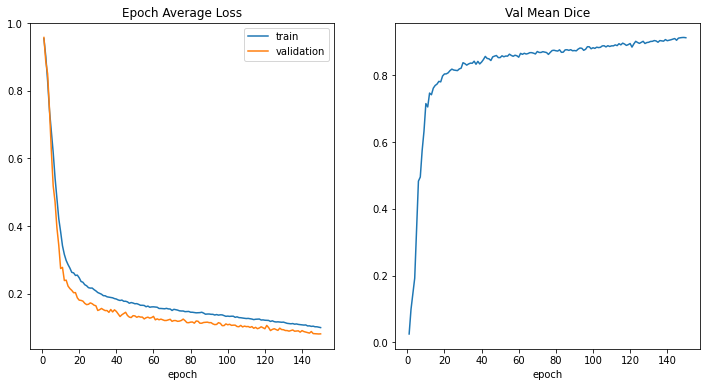

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_train_loss_values))]
plt.xlabel("epoch")
plt.plot(x, epoch_train_loss_values, label="train")
plt.plot(x, epoch_validation_loss_values, label= "validation")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Inference

N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


Total DSC is 0.9136801958084106. 
Total IoU score is 0.8423745036125183.
Dice per class: [0.9031568765640259, 0.9074084758758545, 0.9103732109069824, 0.8980523347854614, 0.9116470813751221, 0.909553050994873, 0.9111635684967041, 0.910991907119751]. 
IoU per class: [0.8354126214981079, 0.8374286890029907, 0.8687853813171387, 0.8291696310043335, 0.8506565093994141, 0.8328588008880615, 0.8728522062301636, 0.83981853723526]


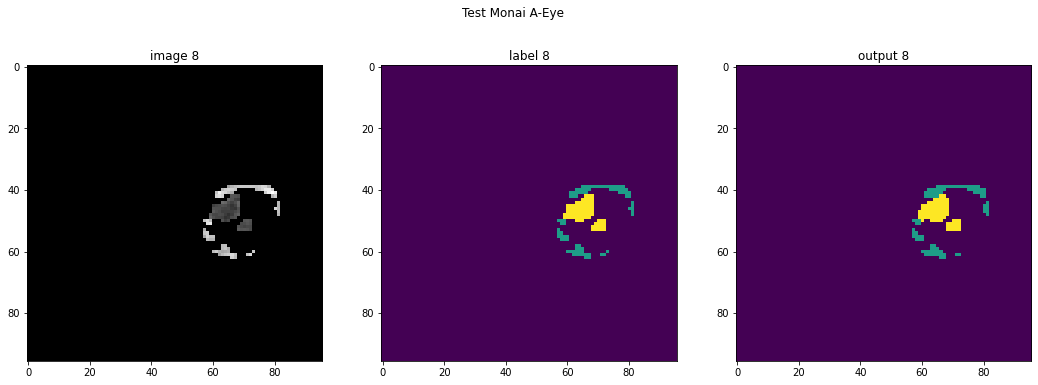

In [17]:
import SimpleITK as sitk

FILE = "v2_num_samples_4.pth"

device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 10,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    dropout = 0.5
).to(device)

model.load_state_dict(torch.load(
    os.path.join(main_dir, FILE)))

# IoU metric
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=10)])
post_label = Compose([AsDiscrete(to_onehot=10)])
iou_metric = MeanIoU(include_background=False, reduction="mean")
metric_iou_values = []

model.eval()

test_loader = validation_loader # This is not right, but just to test and compute similarity metrics

with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        test_inputs, test_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (160, 160, 160)
        sw_batch_size = 4

        val_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model
        )

        test_outputs = [post_pred(j) for j in decollate_batch(val_outputs)]
        test_labels = [post_label(j) for j in decollate_batch(test_labels)]
        iou_metric(y_pred=test_outputs, y=test_labels)
        dice_metric(y_pred=test_outputs, y=test_labels)

        # plot the slice [:, :, 80]
        fig = plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 70], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 70])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 70])
        # print(val_outputs.shape)
        im_result = sitk.GetImageFromArray(np.transpose(torch.argmax(val_outputs, dim=1).detach().cpu().numpy(), (3,2,1,0)))
        if i == 0:
            sitk.WriteImage(im_result, main_dir+'result_'+str(i)+'.nii.gz')
        fig.suptitle('Test Monai A-Eye')
        # plt.show()
    
    # aggregate the final mean dice and IoU results
    dice_array = dice_metric.get_buffer()
    test_metric_dice = dice_metric.aggregate().item()
    iou_array = iou_metric.get_buffer() #(9, 10) --> 25 subjects and 10 classes
    test_metric_iou = iou_metric.aggregate().item()
    print(f"Total DSC is {test_metric_dice}. \nTotal IoU score is {test_metric_iou}.")
    
    # DSC per class
    dice_array_n = dice_array[:,:-1].transpose(0, 1) # to get in each line the IoU of each class (and eliminate NaN values of backgrounf)--> (6, 25)
    dice_array_mean = []
    for i, val in enumerate(dice_array_n):
        dice_array_mean.append(torch.mean(dice_array_n[:, i]).item())

    # IoU per class
    iou_array_n = iou_array[:,:-1].transpose(0, 1) # to get in each line the IoU of each class (and eliminate NaN values of backgrounf)--> (6, 25)
    iou_array_mean = []
    for i, val in enumerate(iou_array_n):
        iou_array_mean.append(torch.mean(iou_array_n[:, i]).item())

    print(f"Dice per class: {dice_array_mean}. \nIoU per class: {iou_array_mean}")